In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from cifar_model import generator,discriminator
import utils
from utils import show_cifar
l = tf.layers

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=1001
)
rng = np.random.RandomState(params_dnn['seed'])  # seed labels

In [3]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)

(1000, 32, 32, 3) (10000, 32, 32, 3)


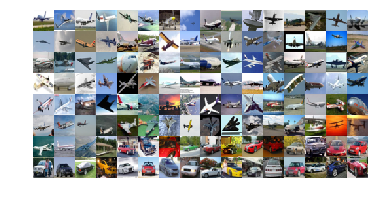

In [4]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print(trainx.shape,testx.shape)
show_cifar(trainx[:128])

In [5]:
def lrelu(x,alpha=0.1):
    return tf.nn.leaky_relu(x,alpha=alpha)

def cnn(x, is_training):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        x = lrelu(l.batch_normalization(l.conv2d(x,96,3,padding='same'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,96,3,padding='same'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,96,3,padding='same'),training=is_training))
        x = l.max_pooling2d(x,2,2)
        x = l.dropout(x,training=is_training)
        x = lrelu(l.batch_normalization(l.conv2d(x,128,3,padding='same'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,128,3,padding='same'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,128,3,padding='same'),training=is_training))
        x = l.max_pooling2d(x,2,2)
        x = l.dropout(x,training=is_training)
        x = lrelu(l.batch_normalization(l.conv2d(x,256,3,padding='valid'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,128,1,padding='same'),training=is_training))
        x = lrelu(l.batch_normalization(l.conv2d(x,128,1,padding='same'),training=is_training))
        x = tf.squeeze(l.average_pooling2d(x,6,6))# global avg pool
        x = l.dense(x,10)
        return x

In [6]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [7]:
# with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
global_step = tf.Variable(0, name='global_step',trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(xloss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
sess = tf.InteractiveSession()

In [9]:
sess.run(tf.global_variables_initializer())

Epoch: 0,Global steps: 20, xloss: 2.24197, training acc: 18.10%, test acc: 10.00%
Epoch: 1,Global steps: 40, xloss: 2.03472, training acc: 29.50%, test acc: 11.31%
Epoch: 2,Global steps: 60, xloss: 1.92251, training acc: 30.80%, test acc: 11.17%
Epoch: 3,Global steps: 80, xloss: 1.83993, training acc: 33.40%, test acc: 10.25%
Epoch: 4,Global steps: 100, xloss: 1.77025, training acc: 36.20%, test acc: 11.11%
Epoch: 5,Global steps: 120, xloss: 1.71080, training acc: 38.80%, test acc: 10.69%
Epoch: 6,Global steps: 140, xloss: 1.66440, training acc: 41.30%, test acc: 11.35%
Epoch: 7,Global steps: 160, xloss: 1.62115, training acc: 41.90%, test acc: 11.46%
Epoch: 8,Global steps: 180, xloss: 1.58708, training acc: 43.50%, test acc: 11.99%
Epoch: 9,Global steps: 200, xloss: 1.54051, training acc: 44.90%, test acc: 12.61%
Epoch: 10,Global steps: 220, xloss: 1.48689, training acc: 47.50%, test acc: 11.40%


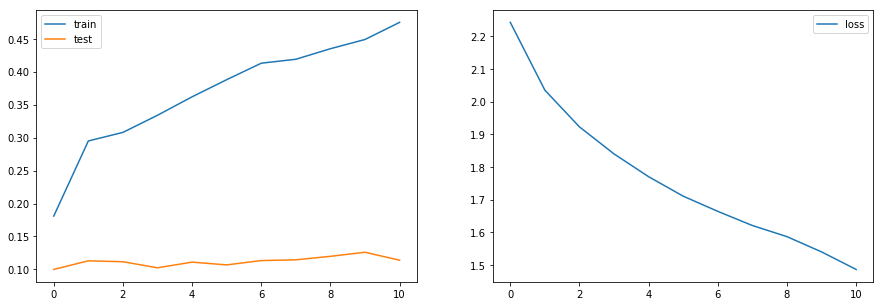

Epoch: 11,Global steps: 240, xloss: 1.46978, training acc: 48.00%, test acc: 11.02%
Epoch: 12,Global steps: 260, xloss: 1.44398, training acc: 48.20%, test acc: 12.42%
Epoch: 13,Global steps: 280, xloss: 1.41492, training acc: 50.60%, test acc: 12.92%
Epoch: 14,Global steps: 300, xloss: 1.39079, training acc: 51.30%, test acc: 13.14%
Epoch: 15,Global steps: 320, xloss: 1.35863, training acc: 53.10%, test acc: 13.92%
Epoch: 16,Global steps: 340, xloss: 1.31882, training acc: 54.50%, test acc: 15.15%
Epoch: 17,Global steps: 360, xloss: 1.29871, training acc: 55.10%, test acc: 17.31%
Epoch: 18,Global steps: 380, xloss: 1.29589, training acc: 54.10%, test acc: 17.38%
Epoch: 19,Global steps: 400, xloss: 1.23942, training acc: 56.20%, test acc: 19.32%
Epoch: 20,Global steps: 420, xloss: 1.24123, training acc: 57.20%, test acc: 22.58%


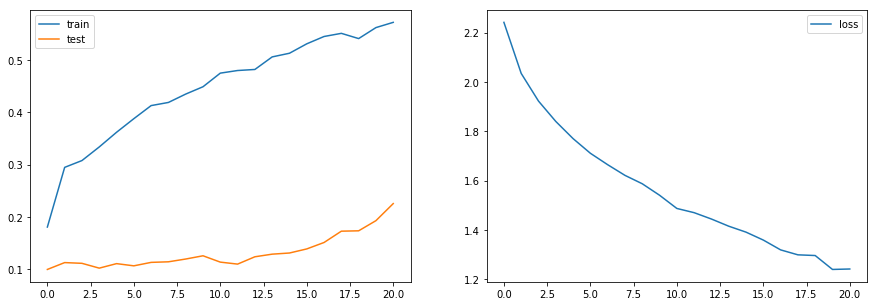

Epoch: 21,Global steps: 440, xloss: 1.20487, training acc: 59.20%, test acc: 22.53%
Epoch: 22,Global steps: 460, xloss: 1.18711, training acc: 59.40%, test acc: 24.57%
Epoch: 23,Global steps: 480, xloss: 1.16572, training acc: 59.80%, test acc: 25.62%
Epoch: 24,Global steps: 500, xloss: 1.13074, training acc: 62.30%, test acc: 28.56%
Epoch: 25,Global steps: 520, xloss: 1.12387, training acc: 61.50%, test acc: 30.64%
Epoch: 26,Global steps: 540, xloss: 1.11916, training acc: 61.30%, test acc: 33.87%
Epoch: 27,Global steps: 560, xloss: 1.07641, training acc: 65.60%, test acc: 32.88%
Epoch: 28,Global steps: 580, xloss: 1.02344, training acc: 67.20%, test acc: 32.25%
Epoch: 29,Global steps: 600, xloss: 1.07282, training acc: 65.00%, test acc: 30.29%
Epoch: 30,Global steps: 620, xloss: 1.00167, training acc: 66.30%, test acc: 37.76%


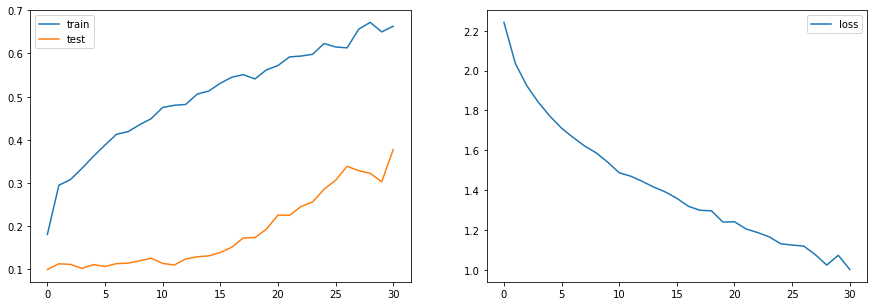

Epoch: 31,Global steps: 640, xloss: 0.97877, training acc: 67.40%, test acc: 31.52%
Epoch: 32,Global steps: 660, xloss: 0.98931, training acc: 66.30%, test acc: 33.89%
Epoch: 33,Global steps: 680, xloss: 0.96448, training acc: 67.10%, test acc: 30.98%
Epoch: 34,Global steps: 700, xloss: 0.91199, training acc: 69.80%, test acc: 30.29%
Epoch: 35,Global steps: 720, xloss: 0.90663, training acc: 71.20%, test acc: 29.69%
Epoch: 36,Global steps: 740, xloss: 0.92551, training acc: 68.90%, test acc: 34.61%
Epoch: 37,Global steps: 760, xloss: 0.88434, training acc: 71.20%, test acc: 33.01%
Epoch: 38,Global steps: 780, xloss: 0.90439, training acc: 70.00%, test acc: 31.84%
Epoch: 39,Global steps: 800, xloss: 0.87375, training acc: 71.30%, test acc: 35.07%
Epoch: 40,Global steps: 820, xloss: 0.84492, training acc: 71.40%, test acc: 31.97%


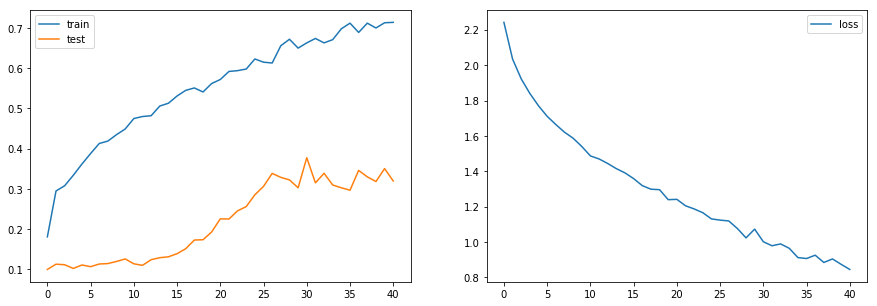

Epoch: 41,Global steps: 840, xloss: 0.82031, training acc: 75.40%, test acc: 31.80%
Epoch: 42,Global steps: 860, xloss: 0.78652, training acc: 75.50%, test acc: 31.52%
Epoch: 43,Global steps: 880, xloss: 0.77876, training acc: 75.20%, test acc: 34.53%
Epoch: 44,Global steps: 900, xloss: 0.78176, training acc: 73.40%, test acc: 30.29%
Epoch: 45,Global steps: 920, xloss: 0.76014, training acc: 76.10%, test acc: 35.36%
Epoch: 46,Global steps: 940, xloss: 0.73077, training acc: 76.70%, test acc: 33.17%
Epoch: 47,Global steps: 960, xloss: 0.71288, training acc: 79.20%, test acc: 29.77%
Epoch: 48,Global steps: 980, xloss: 0.70345, training acc: 77.40%, test acc: 33.57%
Epoch: 49,Global steps: 1000, xloss: 0.71462, training acc: 75.80%, test acc: 32.24%
Epoch: 50,Global steps: 1020, xloss: 0.68862, training acc: 78.90%, test acc: 42.22%


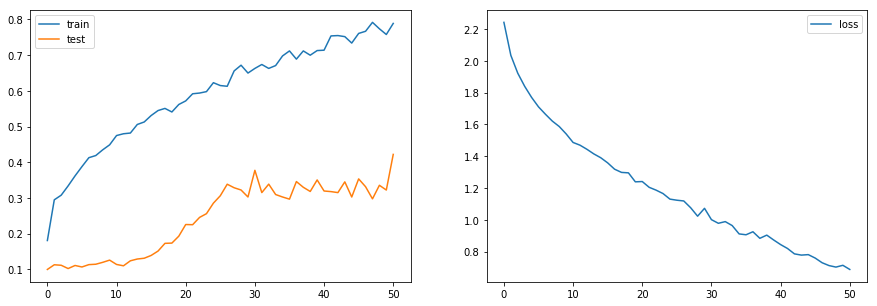

Epoch: 51,Global steps: 1040, xloss: 0.65883, training acc: 78.30%, test acc: 30.40%
Epoch: 52,Global steps: 1060, xloss: 0.69300, training acc: 78.00%, test acc: 32.94%
Epoch: 53,Global steps: 1080, xloss: 0.60170, training acc: 83.10%, test acc: 32.20%
Epoch: 54,Global steps: 1100, xloss: 0.62995, training acc: 81.40%, test acc: 29.23%
Epoch: 55,Global steps: 1120, xloss: 0.63839, training acc: 80.70%, test acc: 40.24%
Epoch: 56,Global steps: 1140, xloss: 0.60502, training acc: 81.40%, test acc: 34.38%
Epoch: 57,Global steps: 1160, xloss: 0.58918, training acc: 82.90%, test acc: 33.42%
Epoch: 58,Global steps: 1180, xloss: 0.58831, training acc: 82.00%, test acc: 31.29%
Epoch: 59,Global steps: 1200, xloss: 0.56568, training acc: 84.90%, test acc: 29.22%
Epoch: 60,Global steps: 1220, xloss: 0.55201, training acc: 84.50%, test acc: 32.13%


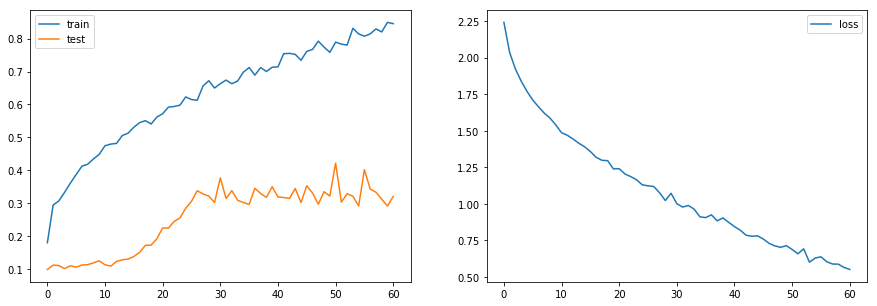

Epoch: 61,Global steps: 1240, xloss: 0.57542, training acc: 82.30%, test acc: 33.79%
Epoch: 62,Global steps: 1260, xloss: 0.53601, training acc: 84.00%, test acc: 35.81%
Epoch: 63,Global steps: 1280, xloss: 0.51006, training acc: 86.70%, test acc: 33.40%
Epoch: 64,Global steps: 1300, xloss: 0.56323, training acc: 83.60%, test acc: 34.07%
Epoch: 65,Global steps: 1320, xloss: 0.52254, training acc: 84.10%, test acc: 37.89%
Epoch: 66,Global steps: 1340, xloss: 0.50618, training acc: 85.50%, test acc: 35.44%
Epoch: 67,Global steps: 1360, xloss: 0.45070, training acc: 87.50%, test acc: 36.35%
Epoch: 68,Global steps: 1380, xloss: 0.46829, training acc: 85.70%, test acc: 34.88%
Epoch: 69,Global steps: 1400, xloss: 0.46745, training acc: 86.10%, test acc: 29.39%
Epoch: 70,Global steps: 1420, xloss: 0.40420, training acc: 89.80%, test acc: 36.46%


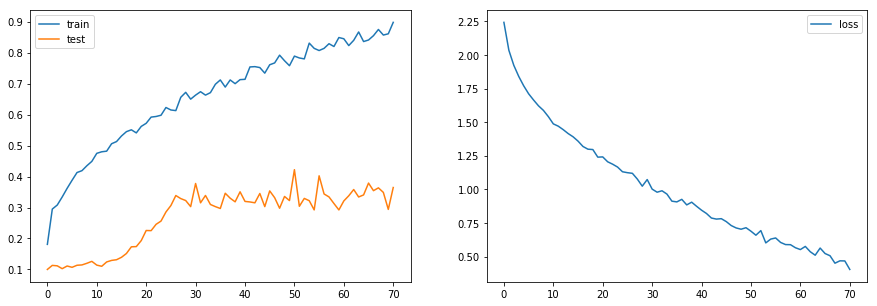

Epoch: 71,Global steps: 1440, xloss: 0.40373, training acc: 89.00%, test acc: 33.53%
Epoch: 72,Global steps: 1460, xloss: 0.41601, training acc: 88.90%, test acc: 31.50%
Epoch: 73,Global steps: 1480, xloss: 0.39997, training acc: 90.00%, test acc: 29.31%
Epoch: 74,Global steps: 1500, xloss: 0.42433, training acc: 87.00%, test acc: 30.96%
Epoch: 75,Global steps: 1520, xloss: 0.39797, training acc: 88.90%, test acc: 32.16%
Epoch: 76,Global steps: 1540, xloss: 0.38577, training acc: 89.40%, test acc: 28.17%
Epoch: 77,Global steps: 1560, xloss: 0.39431, training acc: 89.60%, test acc: 32.84%
Epoch: 78,Global steps: 1580, xloss: 0.37810, training acc: 90.80%, test acc: 28.04%
Epoch: 79,Global steps: 1600, xloss: 0.36317, training acc: 90.90%, test acc: 31.59%
Epoch: 80,Global steps: 1620, xloss: 0.33906, training acc: 91.80%, test acc: 37.82%


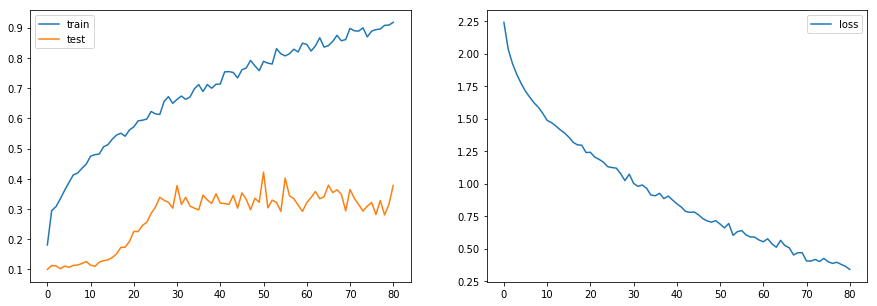

Epoch: 81,Global steps: 1640, xloss: 0.37430, training acc: 88.70%, test acc: 37.35%
Epoch: 82,Global steps: 1660, xloss: 0.38275, training acc: 88.80%, test acc: 30.43%
Epoch: 83,Global steps: 1680, xloss: 0.33234, training acc: 91.10%, test acc: 32.89%
Epoch: 84,Global steps: 1700, xloss: 0.33851, training acc: 91.10%, test acc: 34.20%
Epoch: 85,Global steps: 1720, xloss: 0.33434, training acc: 91.30%, test acc: 32.19%
Epoch: 86,Global steps: 1740, xloss: 0.34436, training acc: 90.40%, test acc: 31.67%
Epoch: 87,Global steps: 1760, xloss: 0.32894, training acc: 92.20%, test acc: 32.09%
Epoch: 88,Global steps: 1780, xloss: 0.29736, training acc: 92.40%, test acc: 36.34%
Epoch: 89,Global steps: 1800, xloss: 0.31744, training acc: 90.80%, test acc: 28.29%
Epoch: 90,Global steps: 1820, xloss: 0.34445, training acc: 90.80%, test acc: 29.49%


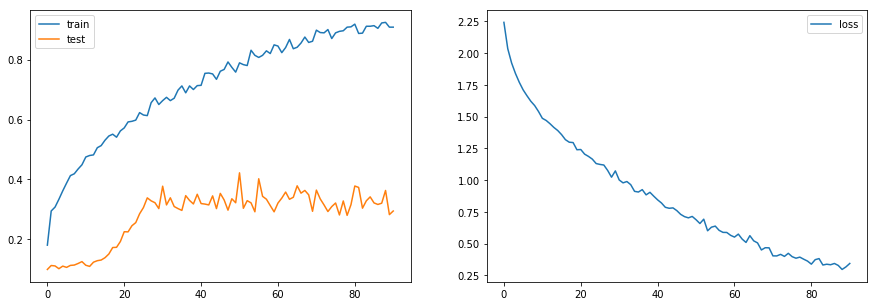

Epoch: 91,Global steps: 1840, xloss: 0.31581, training acc: 91.50%, test acc: 30.72%
Epoch: 92,Global steps: 1860, xloss: 0.25008, training acc: 94.70%, test acc: 29.11%
Epoch: 93,Global steps: 1880, xloss: 0.27647, training acc: 93.00%, test acc: 37.39%
Epoch: 94,Global steps: 1900, xloss: 0.30147, training acc: 91.30%, test acc: 36.47%
Epoch: 95,Global steps: 1920, xloss: 0.28672, training acc: 92.00%, test acc: 36.34%
Epoch: 96,Global steps: 1940, xloss: 0.27569, training acc: 93.20%, test acc: 40.26%
Epoch: 97,Global steps: 1960, xloss: 0.24919, training acc: 94.10%, test acc: 35.22%
Epoch: 98,Global steps: 1980, xloss: 0.27862, training acc: 92.80%, test acc: 32.24%
Epoch: 99,Global steps: 2000, xloss: 0.29281, training acc: 92.00%, test acc: 34.02%
Epoch: 100,Global steps: 2020, xloss: 0.23322, training acc: 94.80%, test acc: 36.70%


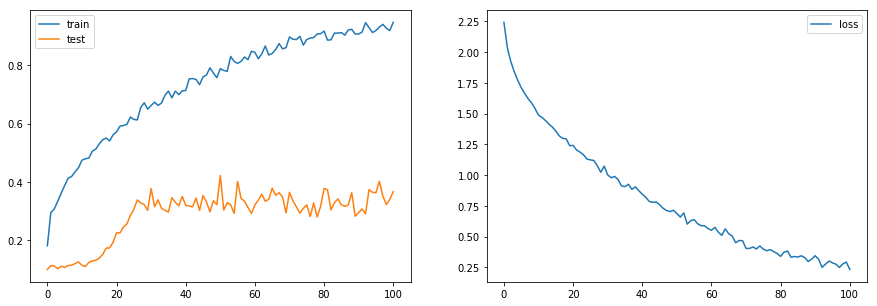

Epoch: 101,Global steps: 2040, xloss: 0.21905, training acc: 95.50%, test acc: 33.75%
Epoch: 102,Global steps: 2060, xloss: 0.22622, training acc: 95.00%, test acc: 35.94%
Epoch: 103,Global steps: 2080, xloss: 0.21415, training acc: 95.40%, test acc: 38.80%
Epoch: 104,Global steps: 2100, xloss: 0.22372, training acc: 95.40%, test acc: 33.96%
Epoch: 105,Global steps: 2120, xloss: 0.22475, training acc: 94.50%, test acc: 36.53%
Epoch: 106,Global steps: 2140, xloss: 0.20345, training acc: 95.60%, test acc: 39.13%
Epoch: 107,Global steps: 2160, xloss: 0.20045, training acc: 95.50%, test acc: 31.17%
Epoch: 108,Global steps: 2180, xloss: 0.20909, training acc: 95.30%, test acc: 36.13%
Epoch: 109,Global steps: 2200, xloss: 0.19004, training acc: 96.20%, test acc: 35.85%
Epoch: 110,Global steps: 2220, xloss: 0.20546, training acc: 94.90%, test acc: 31.98%


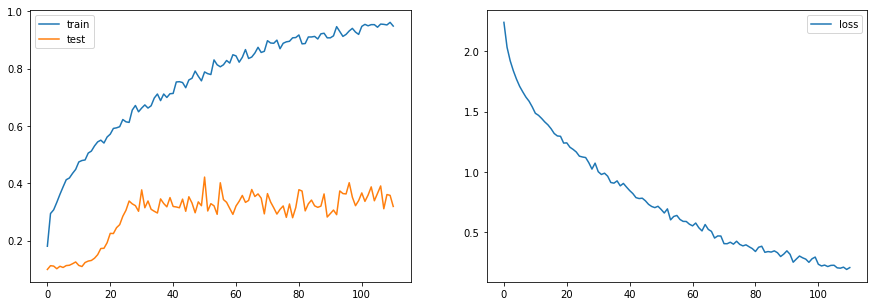

Epoch: 111,Global steps: 2240, xloss: 0.19507, training acc: 95.30%, test acc: 35.44%
Epoch: 112,Global steps: 2260, xloss: 0.18614, training acc: 95.90%, test acc: 37.10%
Epoch: 113,Global steps: 2280, xloss: 0.18068, training acc: 95.90%, test acc: 29.69%
Epoch: 114,Global steps: 2300, xloss: 0.18977, training acc: 96.10%, test acc: 36.14%
Epoch: 115,Global steps: 2320, xloss: 0.17985, training acc: 96.00%, test acc: 32.14%
Epoch: 116,Global steps: 2340, xloss: 0.15852, training acc: 97.20%, test acc: 33.76%
Epoch: 117,Global steps: 2360, xloss: 0.17010, training acc: 96.60%, test acc: 39.87%
Epoch: 118,Global steps: 2380, xloss: 0.16788, training acc: 96.40%, test acc: 33.31%
Epoch: 119,Global steps: 2400, xloss: 0.14259, training acc: 97.30%, test acc: 36.15%
Epoch: 120,Global steps: 2420, xloss: 0.17716, training acc: 95.70%, test acc: 32.46%


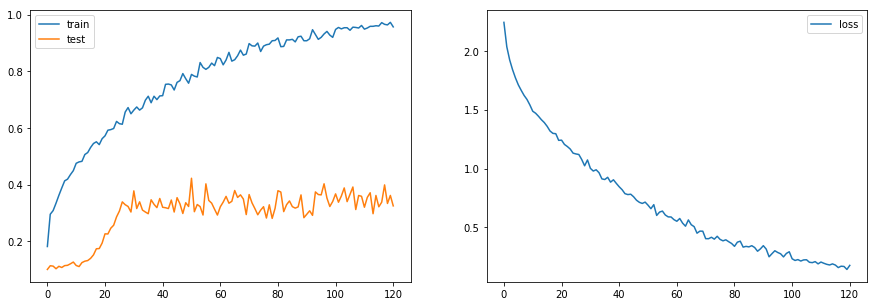

Epoch: 121,Global steps: 2440, xloss: 0.15722, training acc: 96.70%, test acc: 42.37%
Epoch: 122,Global steps: 2460, xloss: 0.16008, training acc: 96.90%, test acc: 34.29%
Epoch: 123,Global steps: 2480, xloss: 0.13309, training acc: 97.90%, test acc: 34.98%
Epoch: 124,Global steps: 2500, xloss: 0.14204, training acc: 97.20%, test acc: 36.42%
Epoch: 125,Global steps: 2520, xloss: 0.13283, training acc: 97.50%, test acc: 34.48%
Epoch: 126,Global steps: 2540, xloss: 0.13534, training acc: 96.80%, test acc: 36.45%
Epoch: 127,Global steps: 2560, xloss: 0.14752, training acc: 97.10%, test acc: 42.66%
Epoch: 128,Global steps: 2580, xloss: 0.10629, training acc: 98.90%, test acc: 40.39%
Epoch: 129,Global steps: 2600, xloss: 0.12978, training acc: 97.80%, test acc: 33.72%
Epoch: 130,Global steps: 2620, xloss: 0.14971, training acc: 95.80%, test acc: 41.40%


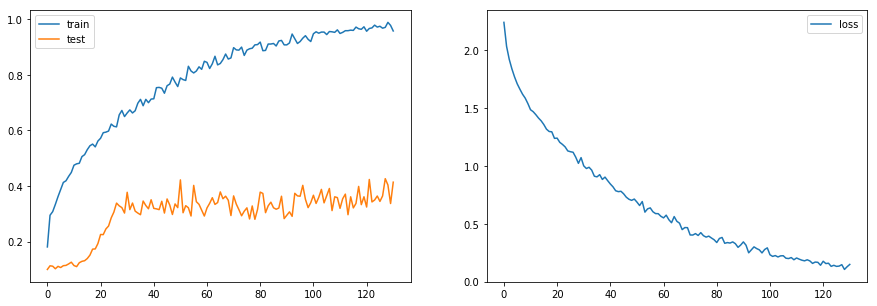

Epoch: 131,Global steps: 2640, xloss: 0.14372, training acc: 96.90%, test acc: 39.98%
Epoch: 132,Global steps: 2660, xloss: 0.13158, training acc: 97.10%, test acc: 37.41%
Epoch: 133,Global steps: 2680, xloss: 0.13446, training acc: 97.10%, test acc: 38.70%
Epoch: 134,Global steps: 2700, xloss: 0.12933, training acc: 97.30%, test acc: 35.48%
Epoch: 135,Global steps: 2720, xloss: 0.13125, training acc: 97.00%, test acc: 36.92%
Epoch: 136,Global steps: 2740, xloss: 0.12076, training acc: 97.60%, test acc: 41.62%
Epoch: 137,Global steps: 2760, xloss: 0.12407, training acc: 97.30%, test acc: 33.55%
Epoch: 138,Global steps: 2780, xloss: 0.14624, training acc: 96.60%, test acc: 34.75%
Epoch: 139,Global steps: 2800, xloss: 0.13819, training acc: 96.80%, test acc: 32.03%
Epoch: 140,Global steps: 2820, xloss: 0.13194, training acc: 97.10%, test acc: 41.91%


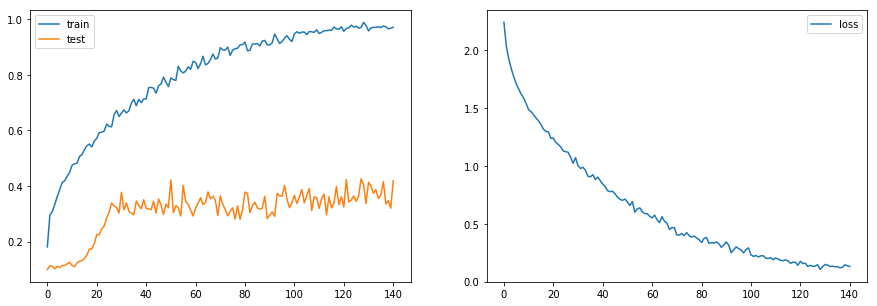

Epoch: 141,Global steps: 2840, xloss: 0.13874, training acc: 96.60%, test acc: 38.01%
Epoch: 142,Global steps: 2860, xloss: 0.09854, training acc: 98.60%, test acc: 32.74%
Epoch: 143,Global steps: 2880, xloss: 0.11993, training acc: 97.20%, test acc: 34.25%
Epoch: 144,Global steps: 2900, xloss: 0.10697, training acc: 98.30%, test acc: 32.63%
Epoch: 145,Global steps: 2920, xloss: 0.11041, training acc: 97.70%, test acc: 36.79%
Epoch: 146,Global steps: 2940, xloss: 0.08855, training acc: 98.40%, test acc: 36.34%
Epoch: 147,Global steps: 2960, xloss: 0.10361, training acc: 98.00%, test acc: 36.53%
Epoch: 148,Global steps: 2980, xloss: 0.09538, training acc: 97.90%, test acc: 36.09%
Epoch: 149,Global steps: 3000, xloss: 0.11085, training acc: 97.40%, test acc: 38.93%
Epoch: 150,Global steps: 3020, xloss: 0.10358, training acc: 98.00%, test acc: 35.58%


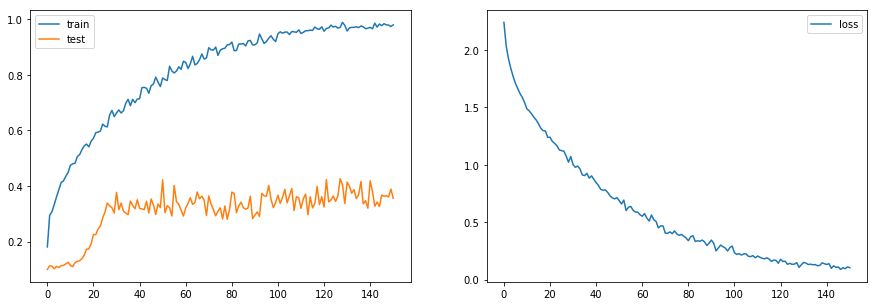

Epoch: 151,Global steps: 3040, xloss: 0.12562, training acc: 97.40%, test acc: 42.63%
Epoch: 152,Global steps: 3060, xloss: 0.11799, training acc: 97.20%, test acc: 41.09%
Epoch: 153,Global steps: 3080, xloss: 0.09358, training acc: 98.70%, test acc: 42.71%
Epoch: 154,Global steps: 3100, xloss: 0.09905, training acc: 98.20%, test acc: 36.71%
Epoch: 155,Global steps: 3120, xloss: 0.08984, training acc: 99.00%, test acc: 35.59%
Epoch: 156,Global steps: 3140, xloss: 0.08159, training acc: 98.50%, test acc: 32.31%
Epoch: 157,Global steps: 3160, xloss: 0.08653, training acc: 98.70%, test acc: 36.90%
Epoch: 158,Global steps: 3180, xloss: 0.09671, training acc: 98.20%, test acc: 38.68%
Epoch: 159,Global steps: 3200, xloss: 0.08289, training acc: 98.50%, test acc: 42.91%
Epoch: 160,Global steps: 3220, xloss: 0.09550, training acc: 98.10%, test acc: 42.02%


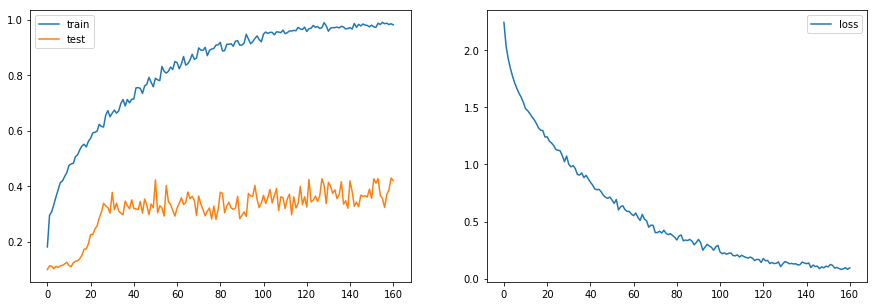

Epoch: 161,Global steps: 3240, xloss: 0.07244, training acc: 98.40%, test acc: 38.07%
Epoch: 162,Global steps: 3260, xloss: 0.07593, training acc: 98.70%, test acc: 43.56%
Epoch: 163,Global steps: 3280, xloss: 0.08234, training acc: 98.50%, test acc: 35.92%
Epoch: 164,Global steps: 3300, xloss: 0.07427, training acc: 98.40%, test acc: 35.22%
Epoch: 165,Global steps: 3320, xloss: 0.08275, training acc: 98.40%, test acc: 45.15%
Epoch: 166,Global steps: 3340, xloss: 0.08157, training acc: 98.40%, test acc: 39.41%
Epoch: 167,Global steps: 3360, xloss: 0.09655, training acc: 98.00%, test acc: 39.44%
Epoch: 168,Global steps: 3380, xloss: 0.09759, training acc: 97.90%, test acc: 40.13%
Epoch: 169,Global steps: 3400, xloss: 0.08751, training acc: 97.90%, test acc: 41.53%
Epoch: 170,Global steps: 3420, xloss: 0.08165, training acc: 98.10%, test acc: 43.32%


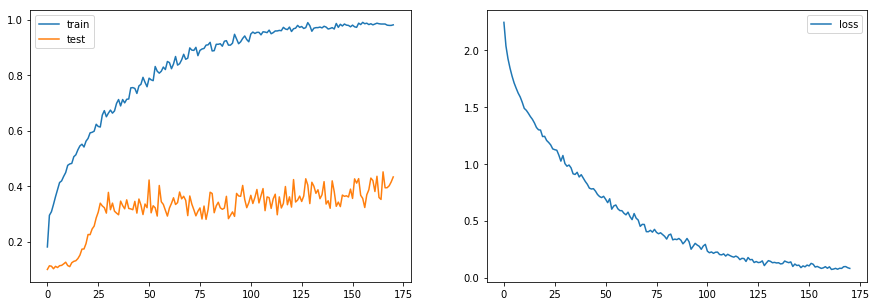

Epoch: 171,Global steps: 3440, xloss: 0.10001, training acc: 97.80%, test acc: 35.82%
Epoch: 172,Global steps: 3460, xloss: 0.10728, training acc: 96.80%, test acc: 40.55%
Epoch: 173,Global steps: 3480, xloss: 0.08709, training acc: 98.40%, test acc: 42.75%
Epoch: 174,Global steps: 3500, xloss: 0.07327, training acc: 98.60%, test acc: 34.81%
Epoch: 175,Global steps: 3520, xloss: 0.07617, training acc: 98.50%, test acc: 38.73%
Epoch: 176,Global steps: 3540, xloss: 0.10787, training acc: 97.20%, test acc: 40.70%
Epoch: 177,Global steps: 3560, xloss: 0.08620, training acc: 98.30%, test acc: 38.77%
Epoch: 178,Global steps: 3580, xloss: 0.10076, training acc: 97.60%, test acc: 43.89%
Epoch: 179,Global steps: 3600, xloss: 0.08877, training acc: 98.10%, test acc: 41.02%
Epoch: 180,Global steps: 3620, xloss: 0.06410, training acc: 99.00%, test acc: 40.40%


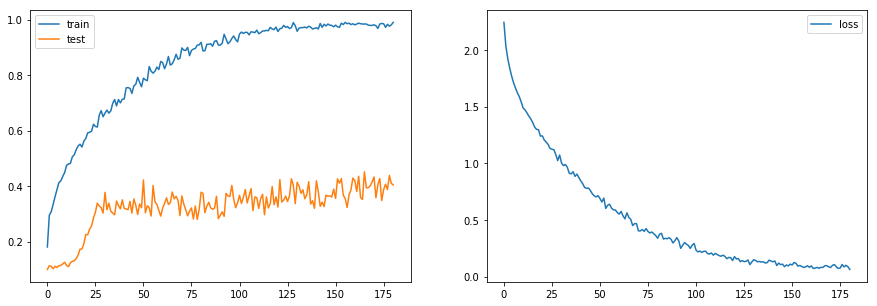

Epoch: 181,Global steps: 3640, xloss: 0.05981, training acc: 99.30%, test acc: 38.34%
Epoch: 182,Global steps: 3660, xloss: 0.06215, training acc: 98.90%, test acc: 42.60%
Epoch: 183,Global steps: 3680, xloss: 0.06379, training acc: 98.90%, test acc: 36.81%
Epoch: 184,Global steps: 3700, xloss: 0.05609, training acc: 99.40%, test acc: 41.11%
Epoch: 185,Global steps: 3720, xloss: 0.05284, training acc: 99.20%, test acc: 36.18%
Epoch: 186,Global steps: 3740, xloss: 0.04828, training acc: 99.40%, test acc: 42.07%
Epoch: 187,Global steps: 3760, xloss: 0.05341, training acc: 99.40%, test acc: 39.63%
Epoch: 188,Global steps: 3780, xloss: 0.05753, training acc: 99.00%, test acc: 36.74%
Epoch: 189,Global steps: 3800, xloss: 0.05139, training acc: 99.40%, test acc: 41.66%
Epoch: 190,Global steps: 3820, xloss: 0.07531, training acc: 98.40%, test acc: 37.45%


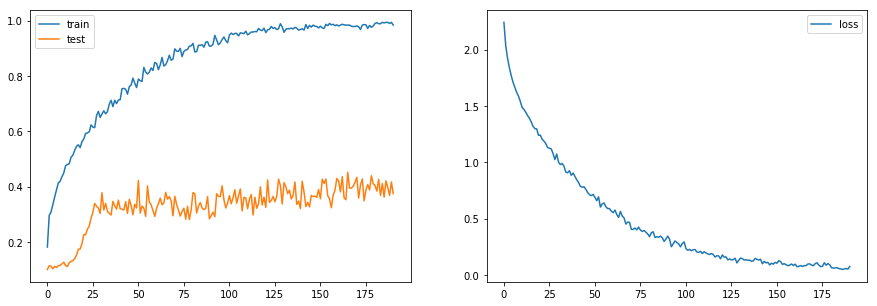

Epoch: 191,Global steps: 3840, xloss: 0.07181, training acc: 98.80%, test acc: 38.27%
Epoch: 192,Global steps: 3860, xloss: 0.08122, training acc: 98.40%, test acc: 42.48%
Epoch: 193,Global steps: 3880, xloss: 0.08703, training acc: 97.20%, test acc: 36.78%
Epoch: 194,Global steps: 3900, xloss: 0.07871, training acc: 98.60%, test acc: 36.06%
Epoch: 195,Global steps: 3920, xloss: 0.06843, training acc: 98.80%, test acc: 43.74%
Epoch: 196,Global steps: 3940, xloss: 0.07246, training acc: 98.40%, test acc: 41.40%
Epoch: 197,Global steps: 3960, xloss: 0.06921, training acc: 98.60%, test acc: 39.23%
Epoch: 198,Global steps: 3980, xloss: 0.07182, training acc: 98.50%, test acc: 40.87%
Epoch: 199,Global steps: 4000, xloss: 0.08604, training acc: 98.00%, test acc: 42.91%
Epoch: 200,Global steps: 4020, xloss: 0.07130, training acc: 98.60%, test acc: 40.35%


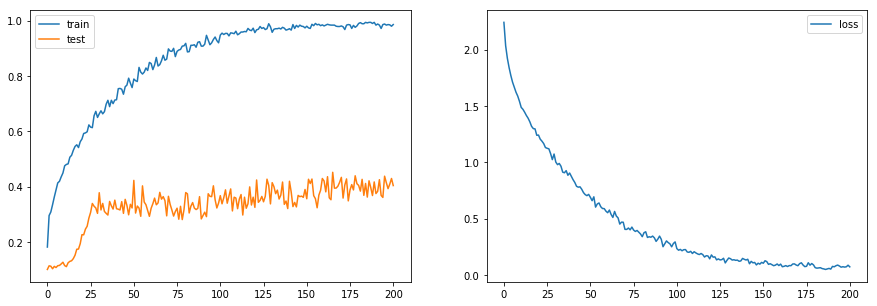

Epoch: 201,Global steps: 4040, xloss: 0.06402, training acc: 98.80%, test acc: 41.02%
Epoch: 202,Global steps: 4060, xloss: 0.06009, training acc: 98.60%, test acc: 40.35%
Epoch: 203,Global steps: 4080, xloss: 0.05469, training acc: 99.30%, test acc: 43.37%
Epoch: 204,Global steps: 4100, xloss: 0.05768, training acc: 98.60%, test acc: 36.77%
Epoch: 205,Global steps: 4120, xloss: 0.06313, training acc: 99.10%, test acc: 41.69%
Epoch: 206,Global steps: 4140, xloss: 0.05616, training acc: 98.80%, test acc: 39.29%
Epoch: 207,Global steps: 4160, xloss: 0.06302, training acc: 98.50%, test acc: 43.98%
Epoch: 208,Global steps: 4180, xloss: 0.05750, training acc: 98.60%, test acc: 43.61%
Epoch: 209,Global steps: 4200, xloss: 0.05287, training acc: 99.00%, test acc: 40.76%
Epoch: 210,Global steps: 4220, xloss: 0.04520, training acc: 99.40%, test acc: 41.93%


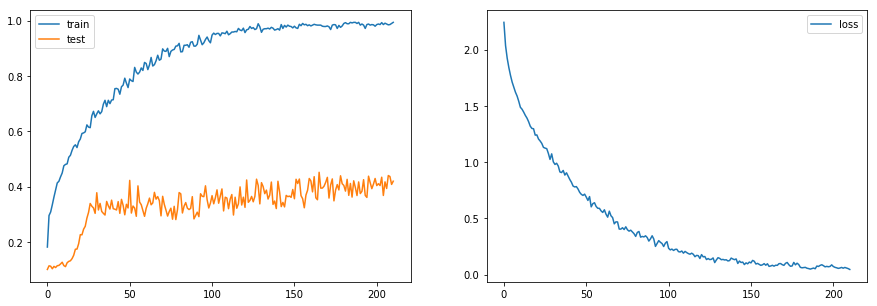

Epoch: 211,Global steps: 4240, xloss: 0.05864, training acc: 98.80%, test acc: 39.72%
Epoch: 212,Global steps: 4260, xloss: 0.07139, training acc: 98.30%, test acc: 42.17%
Epoch: 213,Global steps: 4280, xloss: 0.08491, training acc: 97.60%, test acc: 39.44%
Epoch: 214,Global steps: 4300, xloss: 0.07950, training acc: 97.60%, test acc: 41.18%
Epoch: 215,Global steps: 4320, xloss: 0.07023, training acc: 98.20%, test acc: 39.11%
Epoch: 216,Global steps: 4340, xloss: 0.06588, training acc: 98.60%, test acc: 41.47%
Epoch: 217,Global steps: 4360, xloss: 0.06557, training acc: 98.10%, test acc: 44.97%
Epoch: 218,Global steps: 4380, xloss: 0.06415, training acc: 98.80%, test acc: 44.35%
Epoch: 219,Global steps: 4400, xloss: 0.07880, training acc: 97.90%, test acc: 41.16%
Epoch: 220,Global steps: 4420, xloss: 0.06807, training acc: 98.90%, test acc: 47.77%


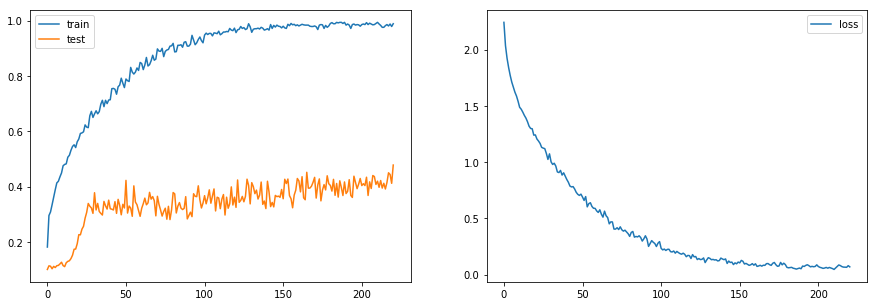

Epoch: 221,Global steps: 4440, xloss: 0.07379, training acc: 98.40%, test acc: 43.82%
Epoch: 222,Global steps: 4460, xloss: 0.04829, training acc: 99.20%, test acc: 44.71%
Epoch: 223,Global steps: 4480, xloss: 0.04806, training acc: 99.20%, test acc: 46.00%
Epoch: 224,Global steps: 4500, xloss: 0.04807, training acc: 98.90%, test acc: 45.18%
Epoch: 225,Global steps: 4520, xloss: 0.05151, training acc: 99.00%, test acc: 43.78%
Epoch: 226,Global steps: 4540, xloss: 0.05931, training acc: 98.70%, test acc: 35.64%
Epoch: 227,Global steps: 4560, xloss: 0.05133, training acc: 99.00%, test acc: 42.77%
Epoch: 228,Global steps: 4580, xloss: 0.05577, training acc: 98.10%, test acc: 45.70%
Epoch: 229,Global steps: 4600, xloss: 0.06292, training acc: 98.50%, test acc: 42.91%
Epoch: 230,Global steps: 4620, xloss: 0.06269, training acc: 98.30%, test acc: 42.88%


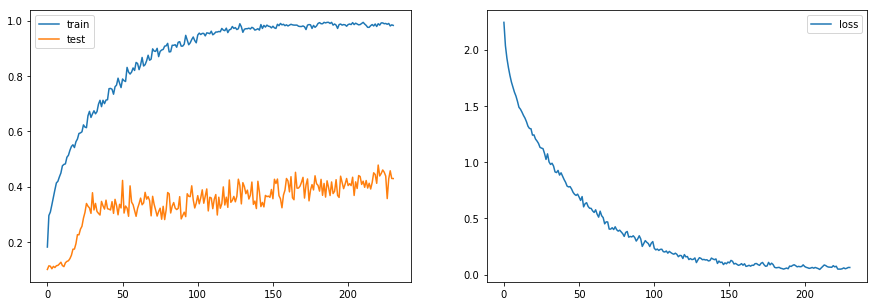

Epoch: 231,Global steps: 4640, xloss: 0.04673, training acc: 99.40%, test acc: 40.90%
Epoch: 232,Global steps: 4660, xloss: 0.03905, training acc: 99.60%, test acc: 43.53%
Epoch: 233,Global steps: 4680, xloss: 0.04551, training acc: 98.90%, test acc: 47.84%
Epoch: 234,Global steps: 4700, xloss: 0.05027, training acc: 99.20%, test acc: 45.24%
Epoch: 235,Global steps: 4720, xloss: 0.03831, training acc: 99.30%, test acc: 43.35%
Epoch: 236,Global steps: 4740, xloss: 0.04472, training acc: 99.00%, test acc: 40.48%
Epoch: 237,Global steps: 4760, xloss: 0.03655, training acc: 99.80%, test acc: 46.12%
Epoch: 238,Global steps: 4780, xloss: 0.03919, training acc: 99.30%, test acc: 40.23%
Epoch: 239,Global steps: 4800, xloss: 0.03728, training acc: 99.40%, test acc: 41.32%
Epoch: 240,Global steps: 4820, xloss: 0.03679, training acc: 99.30%, test acc: 44.12%


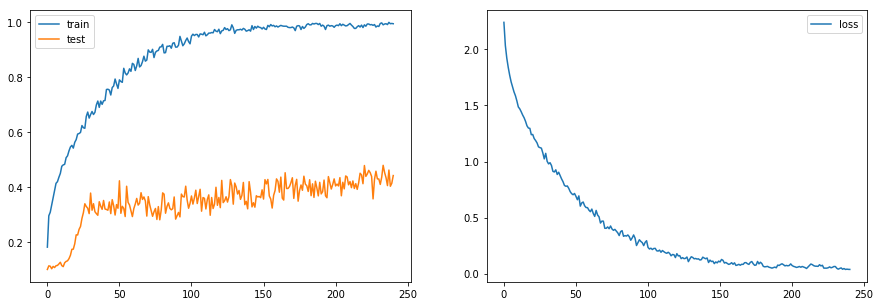

Epoch: 241,Global steps: 4840, xloss: 0.03540, training acc: 99.30%, test acc: 36.80%
Epoch: 242,Global steps: 4860, xloss: 0.04497, training acc: 99.40%, test acc: 40.00%
Epoch: 243,Global steps: 4880, xloss: 0.03582, training acc: 99.60%, test acc: 39.62%
Epoch: 244,Global steps: 4900, xloss: 0.04425, training acc: 99.30%, test acc: 40.48%
Epoch: 245,Global steps: 4920, xloss: 0.04058, training acc: 99.10%, test acc: 37.10%
Epoch: 246,Global steps: 4940, xloss: 0.04458, training acc: 99.20%, test acc: 42.31%
Epoch: 247,Global steps: 4960, xloss: 0.05728, training acc: 99.00%, test acc: 35.16%
Epoch: 248,Global steps: 4980, xloss: 0.05259, training acc: 99.20%, test acc: 38.52%
Epoch: 249,Global steps: 5000, xloss: 0.04533, training acc: 98.90%, test acc: 46.47%
Epoch: 250,Global steps: 5020, xloss: 0.04582, training acc: 99.00%, test acc: 44.90%


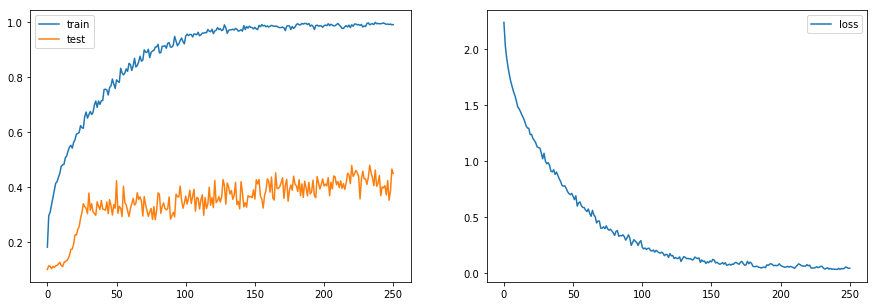

Epoch: 251,Global steps: 5040, xloss: 0.03960, training acc: 99.20%, test acc: 42.45%
Epoch: 252,Global steps: 5060, xloss: 0.02749, training acc: 99.70%, test acc: 41.12%
Epoch: 253,Global steps: 5080, xloss: 0.03190, training acc: 99.20%, test acc: 40.06%
Epoch: 254,Global steps: 5100, xloss: 0.04081, training acc: 99.10%, test acc: 41.56%
Epoch: 255,Global steps: 5120, xloss: 0.04754, training acc: 99.10%, test acc: 36.58%
Epoch: 256,Global steps: 5140, xloss: 0.04832, training acc: 99.20%, test acc: 39.24%
Epoch: 257,Global steps: 5160, xloss: 0.05191, training acc: 98.70%, test acc: 42.86%
Epoch: 258,Global steps: 5180, xloss: 0.04427, training acc: 98.80%, test acc: 44.08%
Epoch: 259,Global steps: 5200, xloss: 0.04430, training acc: 99.20%, test acc: 41.34%
Epoch: 260,Global steps: 5220, xloss: 0.04708, training acc: 99.00%, test acc: 38.71%


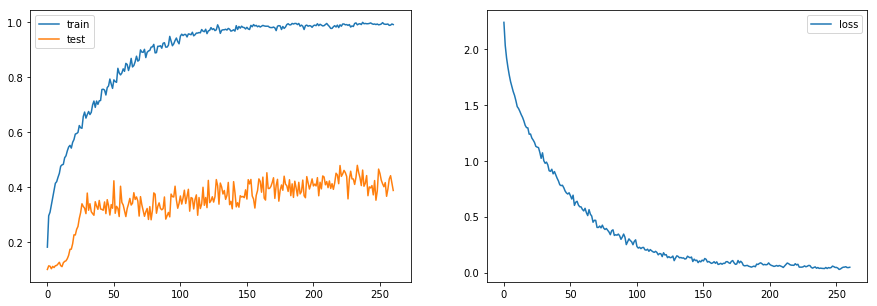

Epoch: 261,Global steps: 5240, xloss: 0.04307, training acc: 99.10%, test acc: 42.92%
Epoch: 262,Global steps: 5260, xloss: 0.04481, training acc: 99.10%, test acc: 42.12%
Epoch: 263,Global steps: 5280, xloss: 0.04297, training acc: 99.20%, test acc: 39.50%
Epoch: 264,Global steps: 5300, xloss: 0.02756, training acc: 99.70%, test acc: 43.20%
Epoch: 265,Global steps: 5320, xloss: 0.03205, training acc: 99.50%, test acc: 37.86%
Epoch: 266,Global steps: 5340, xloss: 0.06856, training acc: 98.00%, test acc: 45.27%
Epoch: 267,Global steps: 5360, xloss: 0.05176, training acc: 98.80%, test acc: 41.95%
Epoch: 268,Global steps: 5380, xloss: 0.05387, training acc: 98.60%, test acc: 42.07%
Epoch: 269,Global steps: 5400, xloss: 0.03320, training acc: 99.60%, test acc: 46.75%
Epoch: 270,Global steps: 5420, xloss: 0.04510, training acc: 98.80%, test acc: 45.33%


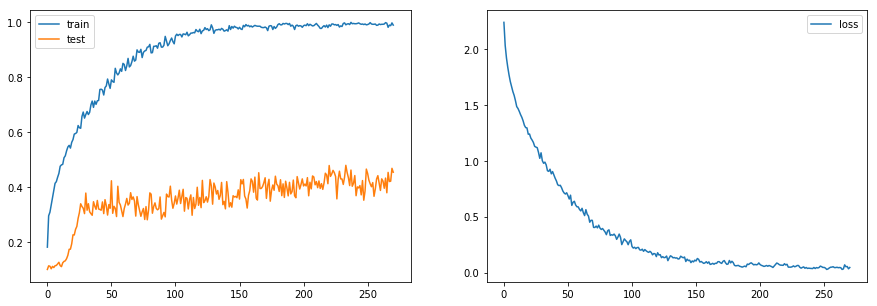

Epoch: 271,Global steps: 5440, xloss: 0.03713, training acc: 99.20%, test acc: 43.90%
Epoch: 272,Global steps: 5460, xloss: 0.02988, training acc: 99.70%, test acc: 45.64%
Epoch: 273,Global steps: 5480, xloss: 0.02780, training acc: 99.60%, test acc: 43.76%
Epoch: 274,Global steps: 5500, xloss: 0.03282, training acc: 99.40%, test acc: 44.86%
Epoch: 275,Global steps: 5520, xloss: 0.03264, training acc: 99.20%, test acc: 46.54%
Epoch: 276,Global steps: 5540, xloss: 0.03542, training acc: 99.20%, test acc: 44.55%
Epoch: 277,Global steps: 5560, xloss: 0.05197, training acc: 98.90%, test acc: 40.31%
Epoch: 278,Global steps: 5580, xloss: 0.02881, training acc: 99.70%, test acc: 39.98%
Epoch: 279,Global steps: 5600, xloss: 0.04393, training acc: 99.20%, test acc: 38.70%
Epoch: 280,Global steps: 5620, xloss: 0.02788, training acc: 99.60%, test acc: 48.51%


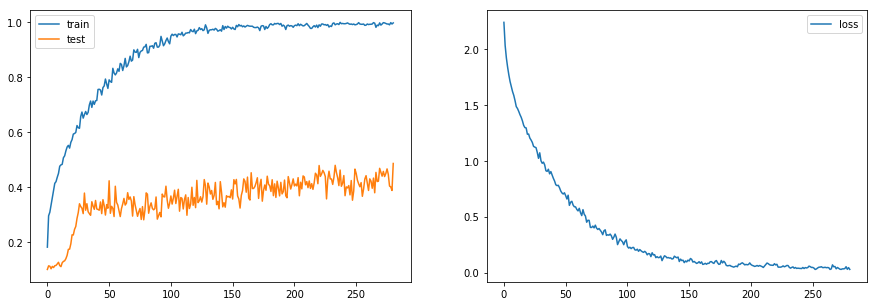

Epoch: 281,Global steps: 5640, xloss: 0.03411, training acc: 99.50%, test acc: 47.91%
Epoch: 282,Global steps: 5660, xloss: 0.03977, training acc: 99.10%, test acc: 42.90%
Epoch: 283,Global steps: 5680, xloss: 0.03706, training acc: 99.30%, test acc: 45.52%
Epoch: 284,Global steps: 5700, xloss: 0.03975, training acc: 99.20%, test acc: 41.99%
Epoch: 285,Global steps: 5720, xloss: 0.04696, training acc: 98.60%, test acc: 48.82%
Epoch: 286,Global steps: 5740, xloss: 0.03219, training acc: 99.10%, test acc: 45.40%
Epoch: 287,Global steps: 5760, xloss: 0.03761, training acc: 98.90%, test acc: 42.94%
Epoch: 288,Global steps: 5780, xloss: 0.03469, training acc: 99.40%, test acc: 44.20%
Epoch: 289,Global steps: 5800, xloss: 0.03625, training acc: 99.10%, test acc: 44.31%
Epoch: 290,Global steps: 5820, xloss: 0.04089, training acc: 98.90%, test acc: 45.15%


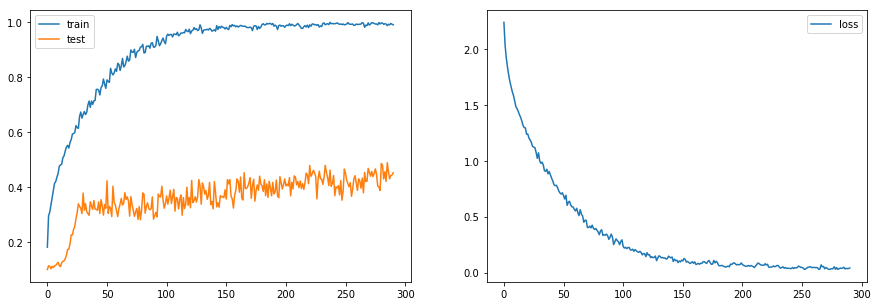

Epoch: 291,Global steps: 5840, xloss: 0.02292, training acc: 99.60%, test acc: 43.53%
Epoch: 292,Global steps: 5860, xloss: 0.03297, training acc: 99.60%, test acc: 48.05%
Epoch: 293,Global steps: 5880, xloss: 0.03060, training acc: 99.40%, test acc: 47.99%
Epoch: 294,Global steps: 5900, xloss: 0.02239, training acc: 99.70%, test acc: 44.41%
Epoch: 295,Global steps: 5920, xloss: 0.02837, training acc: 99.40%, test acc: 47.96%
Epoch: 296,Global steps: 5940, xloss: 0.02700, training acc: 99.60%, test acc: 45.01%
Epoch: 297,Global steps: 5960, xloss: 0.02247, training acc: 99.70%, test acc: 42.66%
Epoch: 298,Global steps: 5980, xloss: 0.02855, training acc: 99.40%, test acc: 43.81%
Epoch: 299,Global steps: 6000, xloss: 0.01836, training acc: 99.80%, test acc: 43.70%
Epoch: 300,Global steps: 6020, xloss: 0.03198, training acc: 99.40%, test acc: 42.50%


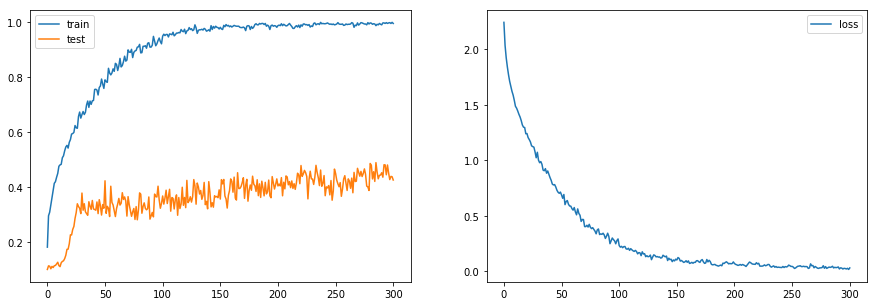

Epoch: 301,Global steps: 6040, xloss: 0.03169, training acc: 99.40%, test acc: 44.31%
Epoch: 302,Global steps: 6060, xloss: 0.04094, training acc: 98.90%, test acc: 38.87%
Epoch: 303,Global steps: 6080, xloss: 0.05389, training acc: 98.10%, test acc: 45.18%
Epoch: 304,Global steps: 6100, xloss: 0.06002, training acc: 98.60%, test acc: 43.77%
Epoch: 305,Global steps: 6120, xloss: 0.03697, training acc: 99.20%, test acc: 45.25%
Epoch: 306,Global steps: 6140, xloss: 0.02491, training acc: 99.70%, test acc: 46.85%
Epoch: 307,Global steps: 6160, xloss: 0.03435, training acc: 99.50%, test acc: 37.58%
Epoch: 308,Global steps: 6180, xloss: 0.03898, training acc: 99.00%, test acc: 44.71%
Epoch: 309,Global steps: 6200, xloss: 0.02920, training acc: 99.30%, test acc: 44.13%
Epoch: 310,Global steps: 6220, xloss: 0.03214, training acc: 99.00%, test acc: 42.09%


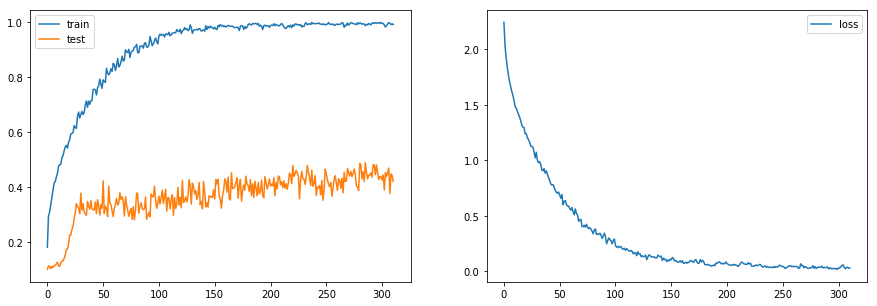

Epoch: 311,Global steps: 6240, xloss: 0.03316, training acc: 98.90%, test acc: 47.06%
Epoch: 312,Global steps: 6260, xloss: 0.04377, training acc: 98.50%, test acc: 34.02%
Epoch: 313,Global steps: 6280, xloss: 0.05717, training acc: 98.70%, test acc: 42.36%
Epoch: 314,Global steps: 6300, xloss: 0.06208, training acc: 98.20%, test acc: 50.73%
Epoch: 315,Global steps: 6320, xloss: 0.05314, training acc: 98.80%, test acc: 40.07%
Epoch: 316,Global steps: 6340, xloss: 0.05288, training acc: 98.70%, test acc: 51.30%
Epoch: 317,Global steps: 6360, xloss: 0.05224, training acc: 98.50%, test acc: 38.03%
Epoch: 318,Global steps: 6380, xloss: 0.04990, training acc: 98.60%, test acc: 44.02%
Epoch: 319,Global steps: 6400, xloss: 0.04893, training acc: 99.00%, test acc: 45.27%
Epoch: 320,Global steps: 6420, xloss: 0.06752, training acc: 97.90%, test acc: 45.45%


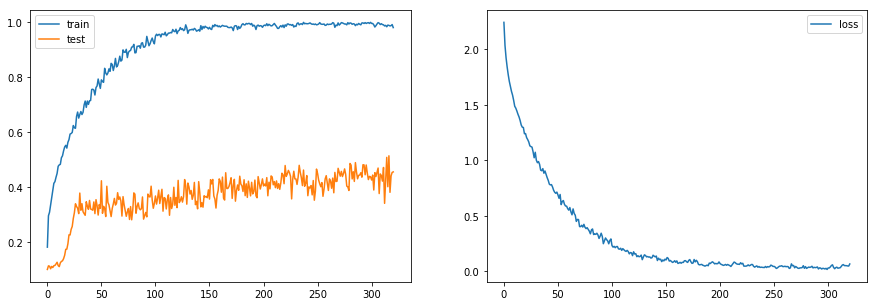

Epoch: 321,Global steps: 6440, xloss: 0.06559, training acc: 98.50%, test acc: 41.02%
Epoch: 322,Global steps: 6460, xloss: 0.05506, training acc: 98.90%, test acc: 44.87%
Epoch: 323,Global steps: 6480, xloss: 0.03357, training acc: 99.20%, test acc: 45.52%
Epoch: 324,Global steps: 6500, xloss: 0.03495, training acc: 99.50%, test acc: 45.71%
Epoch: 325,Global steps: 6520, xloss: 0.02316, training acc: 99.60%, test acc: 49.72%
Epoch: 326,Global steps: 6540, xloss: 0.02553, training acc: 99.40%, test acc: 43.49%
Epoch: 327,Global steps: 6560, xloss: 0.03823, training acc: 99.40%, test acc: 47.73%
Epoch: 328,Global steps: 6580, xloss: 0.03957, training acc: 98.80%, test acc: 37.21%
Epoch: 329,Global steps: 6600, xloss: 0.05895, training acc: 98.50%, test acc: 49.20%
Epoch: 330,Global steps: 6620, xloss: 0.03444, training acc: 99.20%, test acc: 49.56%


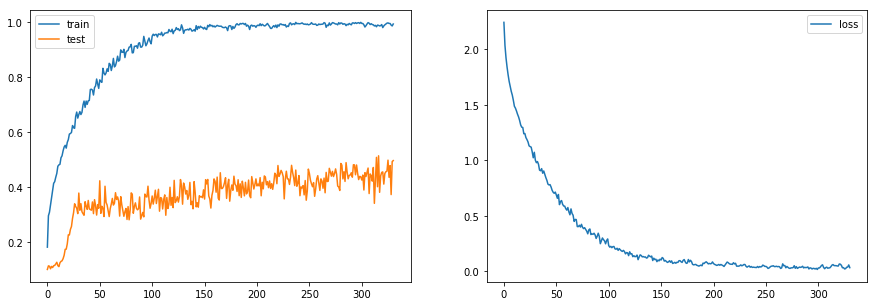

Epoch: 331,Global steps: 6640, xloss: 0.02781, training acc: 99.40%, test acc: 50.36%
Epoch: 332,Global steps: 6660, xloss: 0.03029, training acc: 98.90%, test acc: 48.00%
Epoch: 333,Global steps: 6680, xloss: 0.02365, training acc: 99.90%, test acc: 49.07%
Epoch: 334,Global steps: 6700, xloss: 0.01576, training acc: 99.80%, test acc: 44.80%
Epoch: 335,Global steps: 6720, xloss: 0.02692, training acc: 99.40%, test acc: 47.25%
Epoch: 336,Global steps: 6740, xloss: 0.01904, training acc: 99.80%, test acc: 48.01%
Epoch: 337,Global steps: 6760, xloss: 0.01996, training acc: 99.50%, test acc: 47.50%
Epoch: 338,Global steps: 6780, xloss: 0.02519, training acc: 99.50%, test acc: 44.86%
Epoch: 339,Global steps: 6800, xloss: 0.02971, training acc: 99.00%, test acc: 37.43%
Epoch: 340,Global steps: 6820, xloss: 0.01770, training acc: 99.70%, test acc: 46.55%


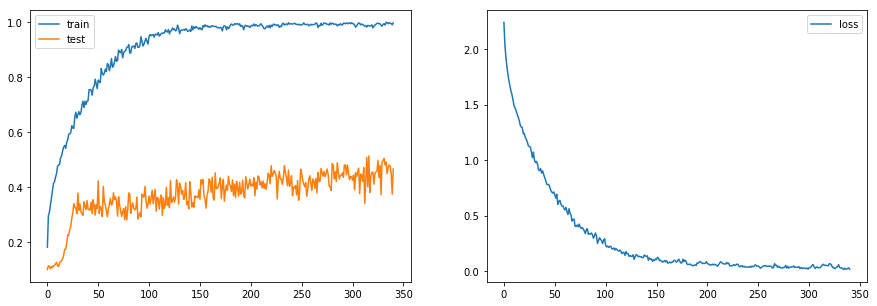

Epoch: 341,Global steps: 6840, xloss: 0.02436, training acc: 99.10%, test acc: 47.57%
Epoch: 342,Global steps: 6860, xloss: 0.02374, training acc: 99.30%, test acc: 50.09%
Epoch: 343,Global steps: 6880, xloss: 0.02952, training acc: 99.40%, test acc: 50.44%
Epoch: 344,Global steps: 6900, xloss: 0.03400, training acc: 98.90%, test acc: 47.91%
Epoch: 345,Global steps: 6920, xloss: 0.03649, training acc: 99.30%, test acc: 41.81%
Epoch: 346,Global steps: 6940, xloss: 0.02789, training acc: 99.50%, test acc: 45.38%
Epoch: 347,Global steps: 6960, xloss: 0.03238, training acc: 99.10%, test acc: 46.66%
Epoch: 348,Global steps: 6980, xloss: 0.03906, training acc: 98.90%, test acc: 40.45%
Epoch: 349,Global steps: 7000, xloss: 0.03199, training acc: 99.10%, test acc: 49.31%
Epoch: 350,Global steps: 7020, xloss: 0.02500, training acc: 99.50%, test acc: 48.31%


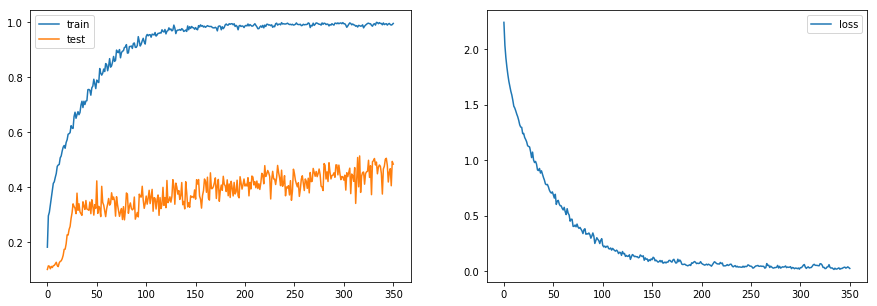

Epoch: 351,Global steps: 7040, xloss: 0.02825, training acc: 99.50%, test acc: 54.20%
Epoch: 352,Global steps: 7060, xloss: 0.03304, training acc: 99.30%, test acc: 44.58%
Epoch: 353,Global steps: 7080, xloss: 0.03692, training acc: 98.80%, test acc: 48.12%
Epoch: 354,Global steps: 7100, xloss: 0.04449, training acc: 98.80%, test acc: 49.32%
Epoch: 355,Global steps: 7120, xloss: 0.03794, training acc: 99.00%, test acc: 46.07%
Epoch: 356,Global steps: 7140, xloss: 0.04802, training acc: 98.90%, test acc: 45.30%
Epoch: 357,Global steps: 7160, xloss: 0.02360, training acc: 99.70%, test acc: 48.31%
Epoch: 358,Global steps: 7180, xloss: 0.01636, training acc: 99.80%, test acc: 47.06%
Epoch: 359,Global steps: 7200, xloss: 0.01539, training acc: 99.70%, test acc: 47.73%
Epoch: 360,Global steps: 7220, xloss: 0.01461, training acc: 99.80%, test acc: 45.32%


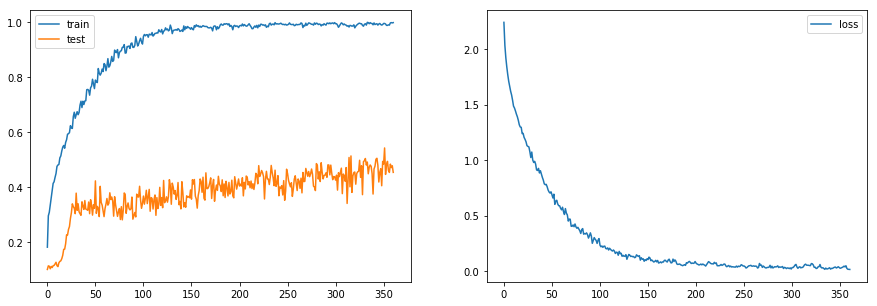

Epoch: 361,Global steps: 7240, xloss: 0.02392, training acc: 99.50%, test acc: 47.05%
Epoch: 362,Global steps: 7260, xloss: 0.01733, training acc: 99.60%, test acc: 49.75%
Epoch: 363,Global steps: 7280, xloss: 0.01823, training acc: 99.70%, test acc: 47.78%
Epoch: 364,Global steps: 7300, xloss: 0.02284, training acc: 99.50%, test acc: 49.52%
Epoch: 365,Global steps: 7320, xloss: 0.02153, training acc: 99.80%, test acc: 46.33%
Epoch: 366,Global steps: 7340, xloss: 0.01741, training acc: 99.60%, test acc: 45.48%
Epoch: 367,Global steps: 7360, xloss: 0.01485, training acc: 99.80%, test acc: 46.40%
Epoch: 368,Global steps: 7380, xloss: 0.02924, training acc: 99.10%, test acc: 51.78%
Epoch: 369,Global steps: 7400, xloss: 0.02290, training acc: 99.40%, test acc: 50.57%
Epoch: 370,Global steps: 7420, xloss: 0.01518, training acc: 99.70%, test acc: 47.21%


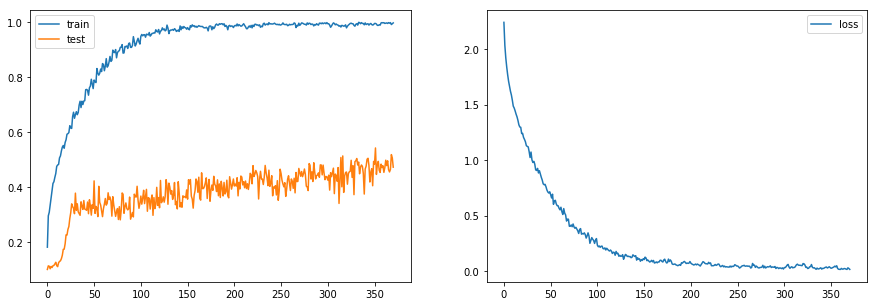

Epoch: 371,Global steps: 7440, xloss: 0.01563, training acc: 99.70%, test acc: 43.07%
Epoch: 372,Global steps: 7460, xloss: 0.01962, training acc: 99.70%, test acc: 48.02%
Epoch: 373,Global steps: 7480, xloss: 0.01681, training acc: 99.50%, test acc: 50.70%
Epoch: 374,Global steps: 7500, xloss: 0.03703, training acc: 98.90%, test acc: 48.41%
Epoch: 375,Global steps: 7520, xloss: 0.04456, training acc: 98.40%, test acc: 44.96%
Epoch: 376,Global steps: 7540, xloss: 0.08524, training acc: 97.60%, test acc: 47.16%
Epoch: 377,Global steps: 7560, xloss: 0.07911, training acc: 97.40%, test acc: 40.14%
Epoch: 378,Global steps: 7580, xloss: 0.06672, training acc: 97.90%, test acc: 44.84%
Epoch: 379,Global steps: 7600, xloss: 0.05228, training acc: 98.60%, test acc: 46.73%
Epoch: 380,Global steps: 7620, xloss: 0.04974, training acc: 98.80%, test acc: 43.39%


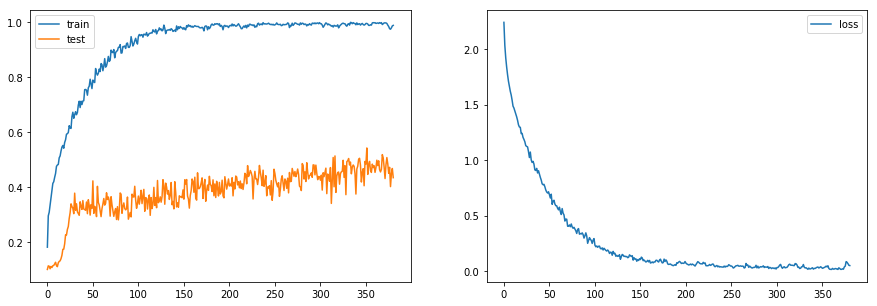

Epoch: 381,Global steps: 7640, xloss: 0.05244, training acc: 99.00%, test acc: 45.47%
Epoch: 382,Global steps: 7660, xloss: 0.04322, training acc: 99.00%, test acc: 49.82%
Epoch: 383,Global steps: 7680, xloss: 0.03678, training acc: 99.30%, test acc: 41.11%
Epoch: 384,Global steps: 7700, xloss: 0.04444, training acc: 99.20%, test acc: 48.42%
Epoch: 385,Global steps: 7720, xloss: 0.03350, training acc: 99.00%, test acc: 44.01%
Epoch: 386,Global steps: 7740, xloss: 0.03764, training acc: 99.10%, test acc: 52.15%
Epoch: 387,Global steps: 7760, xloss: 0.03112, training acc: 99.30%, test acc: 43.50%
Epoch: 388,Global steps: 7780, xloss: 0.02265, training acc: 99.30%, test acc: 47.21%
Epoch: 389,Global steps: 7800, xloss: 0.03781, training acc: 98.90%, test acc: 50.80%
Epoch: 390,Global steps: 7820, xloss: 0.04711, training acc: 98.10%, test acc: 40.32%


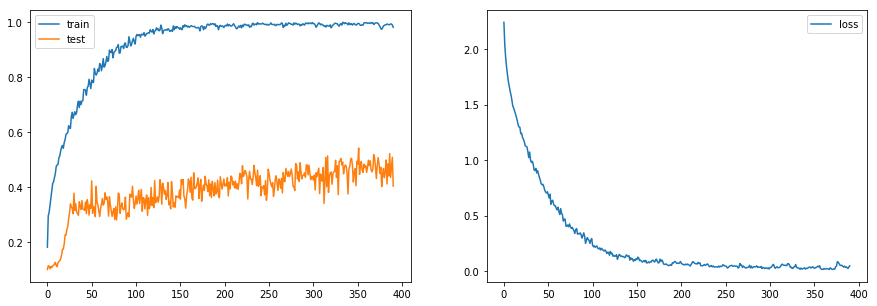

Epoch: 391,Global steps: 7840, xloss: 0.03368, training acc: 99.50%, test acc: 49.72%
Epoch: 392,Global steps: 7860, xloss: 0.02638, training acc: 98.90%, test acc: 43.97%
Epoch: 393,Global steps: 7880, xloss: 0.02244, training acc: 99.60%, test acc: 44.96%
Epoch: 394,Global steps: 7900, xloss: 0.02513, training acc: 99.40%, test acc: 44.57%
Epoch: 395,Global steps: 7920, xloss: 0.02005, training acc: 99.70%, test acc: 49.73%
Epoch: 396,Global steps: 7940, xloss: 0.01887, training acc: 99.50%, test acc: 49.64%
Epoch: 397,Global steps: 7960, xloss: 0.01820, training acc: 99.80%, test acc: 48.04%
Epoch: 398,Global steps: 7980, xloss: 0.01117, training acc: 99.90%, test acc: 45.49%
Epoch: 399,Global steps: 8000, xloss: 0.01262, training acc: 99.90%, test acc: 48.08%
Epoch: 400,Global steps: 8020, xloss: 0.01281, training acc: 99.70%, test acc: 50.77%


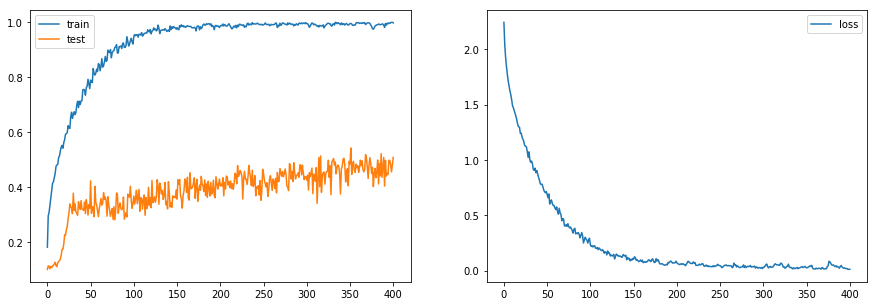

Epoch: 401,Global steps: 8040, xloss: 0.02251, training acc: 99.40%, test acc: 46.80%
Epoch: 402,Global steps: 8060, xloss: 0.01084, training acc: 99.90%, test acc: 48.00%
Epoch: 403,Global steps: 8080, xloss: 0.01191, training acc: 99.90%, test acc: 48.81%
Epoch: 404,Global steps: 8100, xloss: 0.01281, training acc: 99.70%, test acc: 50.42%
Epoch: 405,Global steps: 8120, xloss: 0.01401, training acc: 99.70%, test acc: 48.28%
Epoch: 406,Global steps: 8140, xloss: 0.01698, training acc: 99.60%, test acc: 50.60%
Epoch: 407,Global steps: 8160, xloss: 0.01102, training acc: 99.90%, test acc: 42.90%
Epoch: 408,Global steps: 8180, xloss: 0.01191, training acc: 99.80%, test acc: 48.68%
Epoch: 409,Global steps: 8200, xloss: 0.01372, training acc: 99.80%, test acc: 49.51%
Epoch: 410,Global steps: 8220, xloss: 0.01183, training acc: 100.00%, test acc: 48.17%


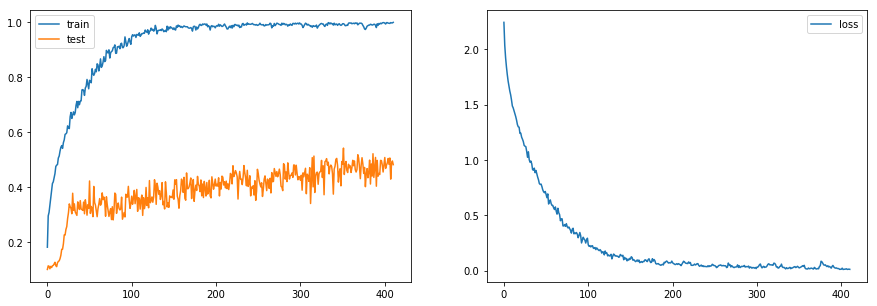

Epoch: 411,Global steps: 8240, xloss: 0.00879, training acc: 99.90%, test acc: 49.41%
Epoch: 412,Global steps: 8260, xloss: 0.01115, training acc: 100.00%, test acc: 46.90%
Epoch: 413,Global steps: 8280, xloss: 0.01208, training acc: 99.70%, test acc: 49.95%
Epoch: 414,Global steps: 8300, xloss: 0.00952, training acc: 99.90%, test acc: 47.47%
Epoch: 415,Global steps: 8320, xloss: 0.00794, training acc: 99.90%, test acc: 47.88%
Epoch: 416,Global steps: 8340, xloss: 0.01977, training acc: 99.50%, test acc: 42.48%
Epoch: 417,Global steps: 8360, xloss: 0.01499, training acc: 99.90%, test acc: 50.80%
Epoch: 418,Global steps: 8380, xloss: 0.01343, training acc: 99.70%, test acc: 45.80%
Epoch: 419,Global steps: 8400, xloss: 0.01315, training acc: 99.70%, test acc: 48.93%
Epoch: 420,Global steps: 8420, xloss: 0.01957, training acc: 99.40%, test acc: 46.92%


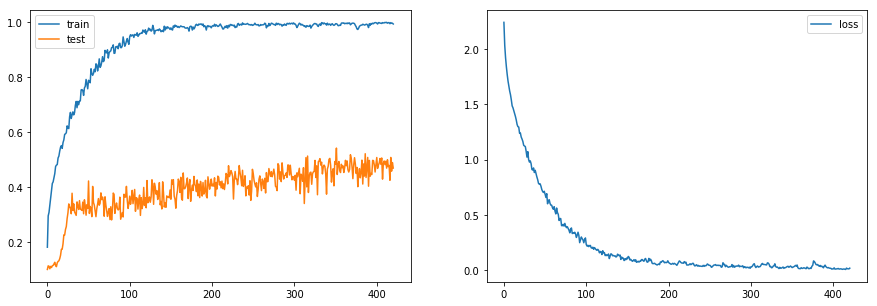

Epoch: 421,Global steps: 8440, xloss: 0.01263, training acc: 100.00%, test acc: 47.66%
Epoch: 422,Global steps: 8460, xloss: 0.01127, training acc: 99.80%, test acc: 46.52%
Epoch: 423,Global steps: 8480, xloss: 0.00981, training acc: 99.90%, test acc: 47.99%
Epoch: 424,Global steps: 8500, xloss: 0.01842, training acc: 99.60%, test acc: 49.82%
Epoch: 425,Global steps: 8520, xloss: 0.01652, training acc: 99.70%, test acc: 47.56%
Epoch: 426,Global steps: 8540, xloss: 0.02480, training acc: 99.40%, test acc: 48.25%
Epoch: 427,Global steps: 8560, xloss: 0.01283, training acc: 99.70%, test acc: 48.38%
Epoch: 428,Global steps: 8580, xloss: 0.01064, training acc: 100.00%, test acc: 49.25%
Epoch: 429,Global steps: 8600, xloss: 0.01007, training acc: 99.90%, test acc: 50.30%
Epoch: 430,Global steps: 8620, xloss: 0.02356, training acc: 99.40%, test acc: 51.63%


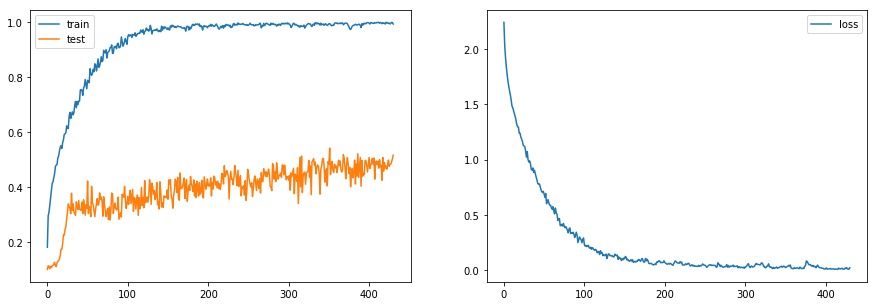

Epoch: 431,Global steps: 8640, xloss: 0.02644, training acc: 99.60%, test acc: 45.32%
Epoch: 432,Global steps: 8660, xloss: 0.01506, training acc: 99.70%, test acc: 51.40%
Epoch: 433,Global steps: 8680, xloss: 0.01771, training acc: 99.80%, test acc: 52.21%
Epoch: 434,Global steps: 8700, xloss: 0.01187, training acc: 99.90%, test acc: 49.65%
Epoch: 435,Global steps: 8720, xloss: 0.01042, training acc: 100.00%, test acc: 50.25%
Epoch: 436,Global steps: 8740, xloss: 0.02036, training acc: 99.60%, test acc: 44.90%
Epoch: 437,Global steps: 8760, xloss: 0.01673, training acc: 99.70%, test acc: 50.89%
Epoch: 438,Global steps: 8780, xloss: 0.02827, training acc: 98.70%, test acc: 49.76%
Epoch: 439,Global steps: 8800, xloss: 0.04497, training acc: 98.80%, test acc: 48.26%
Epoch: 440,Global steps: 8820, xloss: 0.04174, training acc: 98.70%, test acc: 44.99%


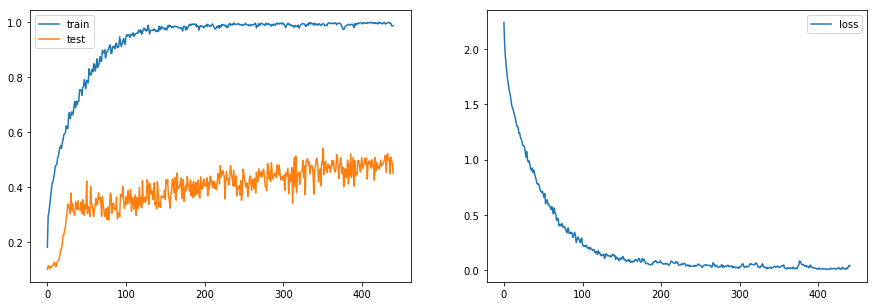

Epoch: 441,Global steps: 8840, xloss: 0.05151, training acc: 98.80%, test acc: 47.20%
Epoch: 442,Global steps: 8860, xloss: 0.09616, training acc: 96.80%, test acc: 46.13%
Epoch: 443,Global steps: 8880, xloss: 0.08673, training acc: 97.70%, test acc: 50.75%
Epoch: 444,Global steps: 8900, xloss: 0.08149, training acc: 97.40%, test acc: 49.22%
Epoch: 445,Global steps: 8920, xloss: 0.09135, training acc: 96.80%, test acc: 44.49%
Epoch: 446,Global steps: 8940, xloss: 0.04206, training acc: 98.80%, test acc: 47.32%
Epoch: 447,Global steps: 8960, xloss: 0.03497, training acc: 99.00%, test acc: 45.37%
Epoch: 448,Global steps: 8980, xloss: 0.03122, training acc: 99.10%, test acc: 45.75%
Epoch: 449,Global steps: 9000, xloss: 0.02066, training acc: 99.40%, test acc: 42.62%
Epoch: 450,Global steps: 9020, xloss: 0.03434, training acc: 98.90%, test acc: 43.77%


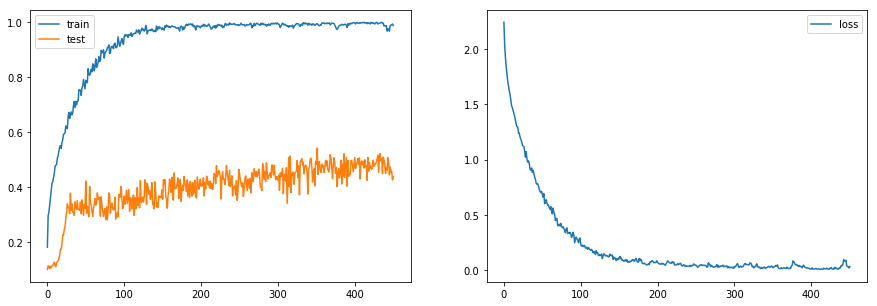

Epoch: 451,Global steps: 9040, xloss: 0.03908, training acc: 98.60%, test acc: 42.72%
Epoch: 452,Global steps: 9060, xloss: 0.03064, training acc: 99.30%, test acc: 47.80%
Epoch: 453,Global steps: 9080, xloss: 0.02390, training acc: 99.10%, test acc: 51.91%
Epoch: 454,Global steps: 9100, xloss: 0.02149, training acc: 99.30%, test acc: 49.19%
Epoch: 455,Global steps: 9120, xloss: 0.02091, training acc: 99.50%, test acc: 47.18%
Epoch: 456,Global steps: 9140, xloss: 0.01416, training acc: 99.80%, test acc: 48.05%
Epoch: 457,Global steps: 9160, xloss: 0.01026, training acc: 99.80%, test acc: 50.69%
Epoch: 458,Global steps: 9180, xloss: 0.01502, training acc: 99.60%, test acc: 50.94%
Epoch: 459,Global steps: 9200, xloss: 0.01101, training acc: 99.80%, test acc: 48.76%
Epoch: 460,Global steps: 9220, xloss: 0.00783, training acc: 100.00%, test acc: 50.86%


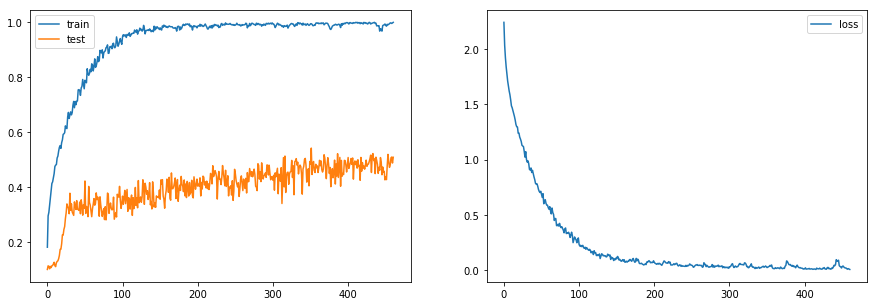

Epoch: 461,Global steps: 9240, xloss: 0.00709, training acc: 100.00%, test acc: 51.78%
Epoch: 462,Global steps: 9260, xloss: 0.00585, training acc: 100.00%, test acc: 52.19%
Epoch: 463,Global steps: 9280, xloss: 0.00621, training acc: 100.00%, test acc: 52.29%
Epoch: 464,Global steps: 9300, xloss: 0.00747, training acc: 99.80%, test acc: 50.79%
Epoch: 465,Global steps: 9320, xloss: 0.00789, training acc: 99.90%, test acc: 49.63%
Epoch: 466,Global steps: 9340, xloss: 0.00800, training acc: 100.00%, test acc: 50.86%
Epoch: 467,Global steps: 9360, xloss: 0.00706, training acc: 100.00%, test acc: 53.60%
Epoch: 468,Global steps: 9380, xloss: 0.00877, training acc: 99.90%, test acc: 49.13%
Epoch: 469,Global steps: 9400, xloss: 0.00951, training acc: 99.90%, test acc: 48.66%
Epoch: 470,Global steps: 9420, xloss: 0.00751, training acc: 100.00%, test acc: 51.32%


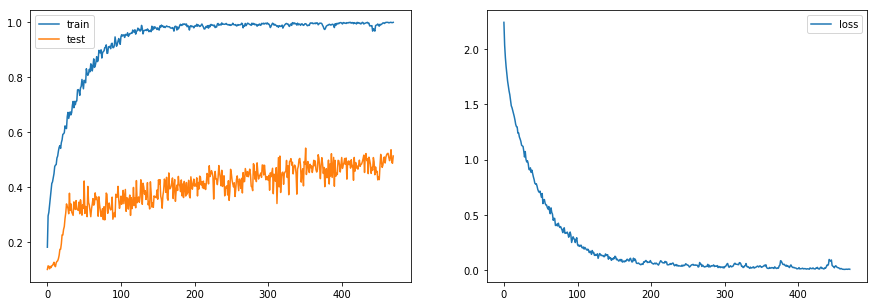

Epoch: 471,Global steps: 9440, xloss: 0.01295, training acc: 99.80%, test acc: 52.43%
Epoch: 472,Global steps: 9460, xloss: 0.01253, training acc: 99.70%, test acc: 49.30%
Epoch: 473,Global steps: 9480, xloss: 0.01566, training acc: 99.40%, test acc: 50.40%
Epoch: 474,Global steps: 9500, xloss: 0.02391, training acc: 99.30%, test acc: 50.28%
Epoch: 475,Global steps: 9520, xloss: 0.02514, training acc: 99.10%, test acc: 51.24%
Epoch: 476,Global steps: 9540, xloss: 0.01943, training acc: 99.70%, test acc: 48.14%
Epoch: 477,Global steps: 9560, xloss: 0.01740, training acc: 99.50%, test acc: 49.25%
Epoch: 478,Global steps: 9580, xloss: 0.01095, training acc: 99.80%, test acc: 49.81%
Epoch: 479,Global steps: 9600, xloss: 0.01176, training acc: 99.70%, test acc: 50.39%
Epoch: 480,Global steps: 9620, xloss: 0.01540, training acc: 99.50%, test acc: 49.89%


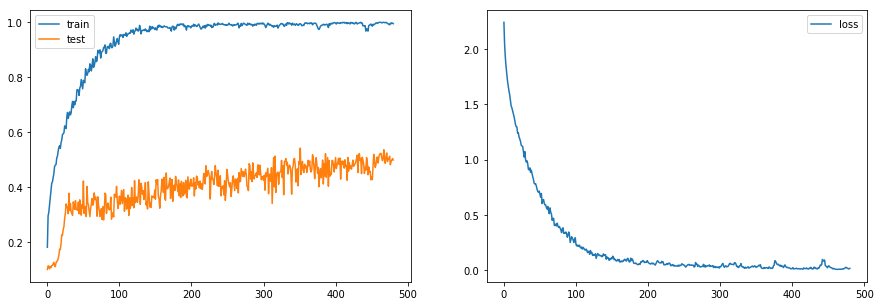

Epoch: 481,Global steps: 9640, xloss: 0.01491, training acc: 99.50%, test acc: 49.26%
Epoch: 482,Global steps: 9660, xloss: 0.01201, training acc: 99.90%, test acc: 52.53%
Epoch: 483,Global steps: 9680, xloss: 0.01669, training acc: 99.40%, test acc: 49.09%
Epoch: 484,Global steps: 9700, xloss: 0.02215, training acc: 99.40%, test acc: 49.58%
Epoch: 485,Global steps: 9720, xloss: 0.02359, training acc: 99.50%, test acc: 47.02%
Epoch: 486,Global steps: 9740, xloss: 0.01575, training acc: 99.80%, test acc: 52.59%
Epoch: 487,Global steps: 9760, xloss: 0.02152, training acc: 99.60%, test acc: 48.05%
Epoch: 488,Global steps: 9780, xloss: 0.01395, training acc: 99.70%, test acc: 49.58%
Epoch: 489,Global steps: 9800, xloss: 0.02675, training acc: 99.40%, test acc: 42.18%
Epoch: 490,Global steps: 9820, xloss: 0.01385, training acc: 99.80%, test acc: 46.32%


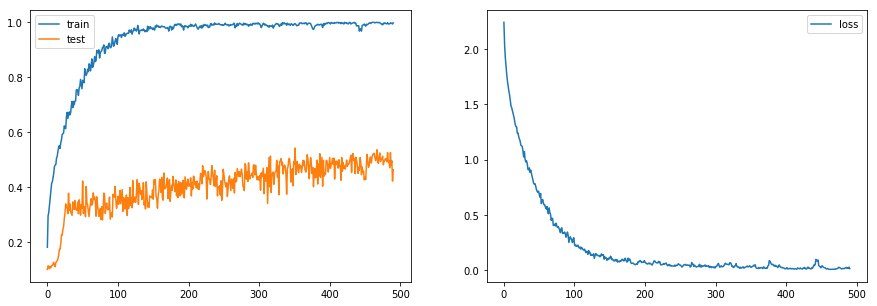

Epoch: 491,Global steps: 9840, xloss: 0.01049, training acc: 99.80%, test acc: 49.51%
Epoch: 492,Global steps: 9860, xloss: 0.01155, training acc: 99.80%, test acc: 47.30%
Epoch: 493,Global steps: 9880, xloss: 0.01706, training acc: 99.60%, test acc: 52.64%
Epoch: 494,Global steps: 9900, xloss: 0.02898, training acc: 99.70%, test acc: 47.39%
Epoch: 495,Global steps: 9920, xloss: 0.03449, training acc: 99.00%, test acc: 49.57%
Epoch: 496,Global steps: 9940, xloss: 0.02961, training acc: 99.20%, test acc: 48.39%
Epoch: 497,Global steps: 9960, xloss: 0.02380, training acc: 99.70%, test acc: 51.71%
Epoch: 498,Global steps: 9980, xloss: 0.02706, training acc: 99.40%, test acc: 47.43%
Epoch: 499,Global steps: 10000, xloss: 0.02028, training acc: 99.70%, test acc: 50.68%
Epoch: 500,Global steps: 10020, xloss: 0.01800, training acc: 99.50%, test acc: 48.69%


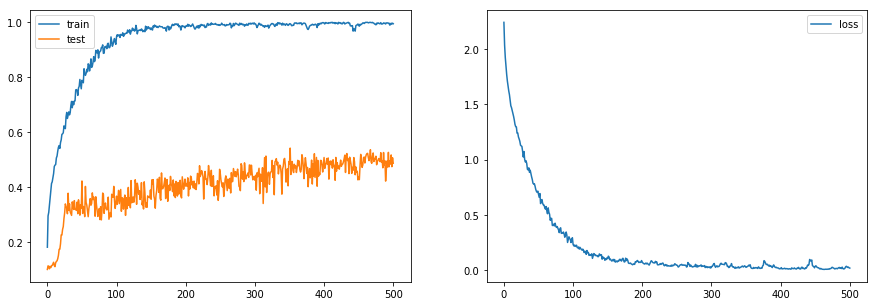

Epoch: 501,Global steps: 10040, xloss: 0.02390, training acc: 99.40%, test acc: 44.13%
Epoch: 502,Global steps: 10060, xloss: 0.02621, training acc: 99.40%, test acc: 45.86%
Epoch: 503,Global steps: 10080, xloss: 0.03306, training acc: 99.10%, test acc: 44.12%
Epoch: 504,Global steps: 10100, xloss: 0.02456, training acc: 99.40%, test acc: 44.77%
Epoch: 505,Global steps: 10120, xloss: 0.03504, training acc: 99.20%, test acc: 46.48%
Epoch: 506,Global steps: 10140, xloss: 0.01745, training acc: 99.40%, test acc: 46.88%
Epoch: 507,Global steps: 10160, xloss: 0.02873, training acc: 99.20%, test acc: 52.40%
Epoch: 508,Global steps: 10180, xloss: 0.03363, training acc: 99.00%, test acc: 43.06%
Epoch: 509,Global steps: 10200, xloss: 0.01938, training acc: 99.60%, test acc: 50.99%
Epoch: 510,Global steps: 10220, xloss: 0.02886, training acc: 99.20%, test acc: 51.28%


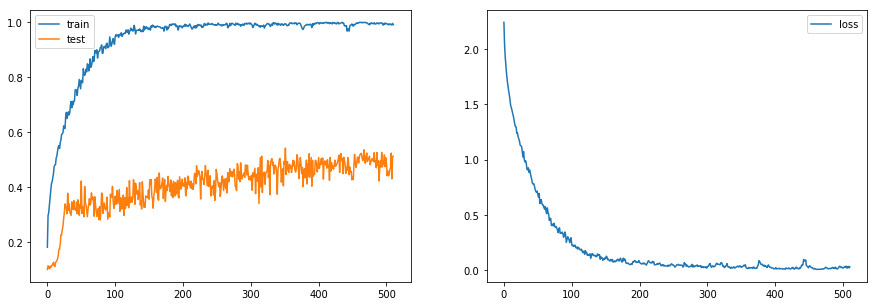

Epoch: 511,Global steps: 10240, xloss: 0.02843, training acc: 98.90%, test acc: 52.09%
Epoch: 512,Global steps: 10260, xloss: 0.02073, training acc: 99.80%, test acc: 52.20%
Epoch: 513,Global steps: 10280, xloss: 0.01075, training acc: 99.80%, test acc: 50.85%
Epoch: 514,Global steps: 10300, xloss: 0.01198, training acc: 99.80%, test acc: 53.57%
Epoch: 515,Global steps: 10320, xloss: 0.01162, training acc: 99.90%, test acc: 51.03%
Epoch: 516,Global steps: 10340, xloss: 0.00593, training acc: 100.00%, test acc: 51.94%
Epoch: 517,Global steps: 10360, xloss: 0.00651, training acc: 100.00%, test acc: 51.90%
Epoch: 518,Global steps: 10380, xloss: 0.00419, training acc: 100.00%, test acc: 51.13%
Epoch: 519,Global steps: 10400, xloss: 0.00575, training acc: 99.90%, test acc: 53.20%
Epoch: 520,Global steps: 10420, xloss: 0.00434, training acc: 100.00%, test acc: 51.05%


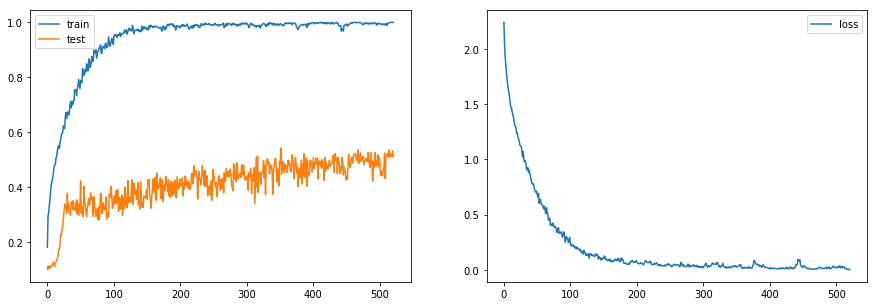

Epoch: 521,Global steps: 10440, xloss: 0.00396, training acc: 100.00%, test acc: 51.31%
Epoch: 522,Global steps: 10460, xloss: 0.00685, training acc: 99.80%, test acc: 51.52%
Epoch: 523,Global steps: 10480, xloss: 0.00912, training acc: 99.90%, test acc: 50.41%
Epoch: 524,Global steps: 10500, xloss: 0.00997, training acc: 99.70%, test acc: 50.39%
Epoch: 525,Global steps: 10520, xloss: 0.01079, training acc: 99.80%, test acc: 51.42%
Epoch: 526,Global steps: 10540, xloss: 0.01497, training acc: 99.60%, test acc: 49.28%
Epoch: 527,Global steps: 10560, xloss: 0.01570, training acc: 99.60%, test acc: 46.70%
Epoch: 528,Global steps: 10580, xloss: 0.00811, training acc: 99.90%, test acc: 49.55%
Epoch: 529,Global steps: 10600, xloss: 0.00682, training acc: 100.00%, test acc: 52.24%
Epoch: 530,Global steps: 10620, xloss: 0.00593, training acc: 99.90%, test acc: 50.23%


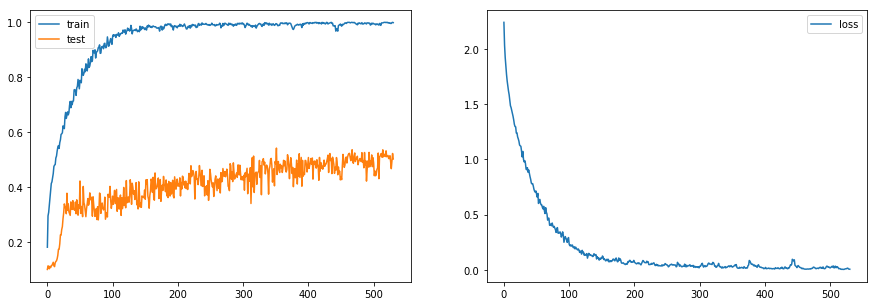

Epoch: 531,Global steps: 10640, xloss: 0.00491, training acc: 99.90%, test acc: 50.51%
Epoch: 532,Global steps: 10660, xloss: 0.00453, training acc: 100.00%, test acc: 50.78%
Epoch: 533,Global steps: 10680, xloss: 0.00485, training acc: 100.00%, test acc: 48.37%
Epoch: 534,Global steps: 10700, xloss: 0.00520, training acc: 100.00%, test acc: 49.47%
Epoch: 535,Global steps: 10720, xloss: 0.00607, training acc: 100.00%, test acc: 51.34%
Epoch: 536,Global steps: 10740, xloss: 0.00601, training acc: 99.90%, test acc: 52.35%
Epoch: 537,Global steps: 10760, xloss: 0.00744, training acc: 99.80%, test acc: 51.60%
Epoch: 538,Global steps: 10780, xloss: 0.00490, training acc: 100.00%, test acc: 50.45%
Epoch: 539,Global steps: 10800, xloss: 0.00360, training acc: 100.00%, test acc: 50.87%
Epoch: 540,Global steps: 10820, xloss: 0.00640, training acc: 99.80%, test acc: 50.47%


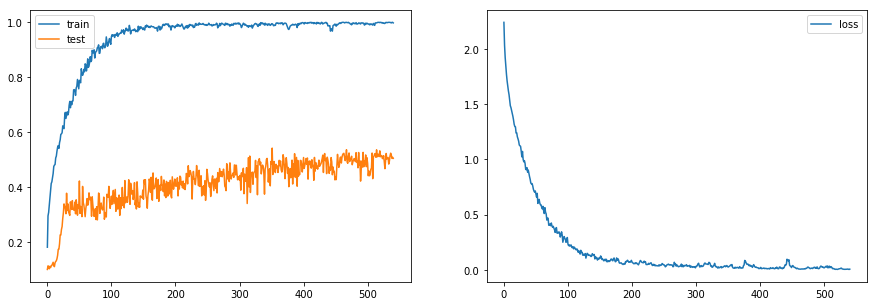

Epoch: 541,Global steps: 10840, xloss: 0.01027, training acc: 99.70%, test acc: 51.20%
Epoch: 542,Global steps: 10860, xloss: 0.00406, training acc: 100.00%, test acc: 51.97%
Epoch: 543,Global steps: 10880, xloss: 0.00919, training acc: 99.70%, test acc: 43.53%
Epoch: 544,Global steps: 10900, xloss: 0.01793, training acc: 99.50%, test acc: 45.43%
Epoch: 545,Global steps: 10920, xloss: 0.01571, training acc: 99.70%, test acc: 39.38%
Epoch: 546,Global steps: 10940, xloss: 0.03489, training acc: 99.20%, test acc: 47.13%
Epoch: 547,Global steps: 10960, xloss: 0.04523, training acc: 98.60%, test acc: 48.47%
Epoch: 548,Global steps: 10980, xloss: 0.02106, training acc: 99.50%, test acc: 47.23%
Epoch: 549,Global steps: 11000, xloss: 0.06122, training acc: 98.70%, test acc: 41.62%
Epoch: 550,Global steps: 11020, xloss: 0.05252, training acc: 98.40%, test acc: 48.08%


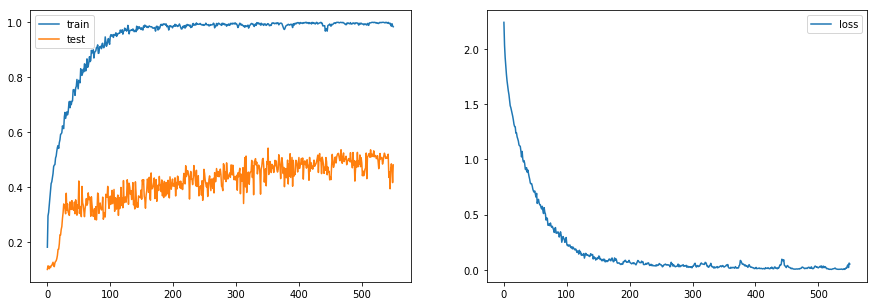

Epoch: 551,Global steps: 11040, xloss: 0.02574, training acc: 99.50%, test acc: 47.59%
Epoch: 552,Global steps: 11060, xloss: 0.01910, training acc: 99.60%, test acc: 49.06%
Epoch: 553,Global steps: 11080, xloss: 0.01878, training acc: 99.50%, test acc: 51.59%
Epoch: 554,Global steps: 11100, xloss: 0.02732, training acc: 99.40%, test acc: 50.44%
Epoch: 555,Global steps: 11120, xloss: 0.01754, training acc: 99.50%, test acc: 47.14%
Epoch: 556,Global steps: 11140, xloss: 0.01169, training acc: 99.90%, test acc: 49.86%
Epoch: 557,Global steps: 11160, xloss: 0.00960, training acc: 99.80%, test acc: 51.45%
Epoch: 558,Global steps: 11180, xloss: 0.01786, training acc: 99.50%, test acc: 51.30%
Epoch: 559,Global steps: 11200, xloss: 0.01729, training acc: 99.60%, test acc: 50.73%
Epoch: 560,Global steps: 11220, xloss: 0.01886, training acc: 99.50%, test acc: 44.81%


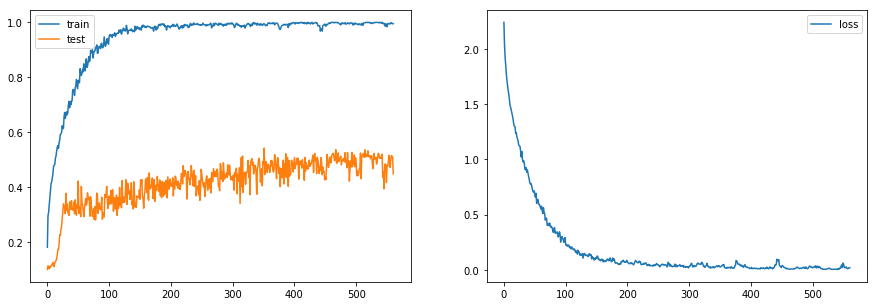

Epoch: 561,Global steps: 11240, xloss: 0.01987, training acc: 99.30%, test acc: 50.36%
Epoch: 562,Global steps: 11260, xloss: 0.01587, training acc: 99.80%, test acc: 48.58%
Epoch: 563,Global steps: 11280, xloss: 0.01050, training acc: 99.90%, test acc: 51.05%
Epoch: 564,Global steps: 11300, xloss: 0.00958, training acc: 99.80%, test acc: 51.01%
Epoch: 565,Global steps: 11320, xloss: 0.02015, training acc: 99.50%, test acc: 48.12%
Epoch: 566,Global steps: 11340, xloss: 0.02426, training acc: 99.40%, test acc: 51.71%
Epoch: 567,Global steps: 11360, xloss: 0.02181, training acc: 99.30%, test acc: 49.95%
Epoch: 568,Global steps: 11380, xloss: 0.02705, training acc: 99.40%, test acc: 50.53%
Epoch: 569,Global steps: 11400, xloss: 0.05300, training acc: 98.00%, test acc: 48.63%
Epoch: 570,Global steps: 11420, xloss: 0.03777, training acc: 99.00%, test acc: 51.71%


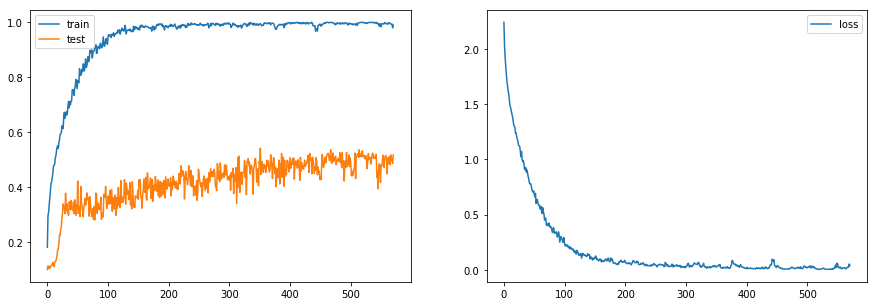

Epoch: 571,Global steps: 11440, xloss: 0.02538, training acc: 99.30%, test acc: 49.35%
Epoch: 572,Global steps: 11460, xloss: 0.01941, training acc: 99.70%, test acc: 51.79%
Epoch: 573,Global steps: 11480, xloss: 0.01739, training acc: 99.70%, test acc: 51.49%
Epoch: 574,Global steps: 11500, xloss: 0.03623, training acc: 99.00%, test acc: 45.76%
Epoch: 575,Global steps: 11520, xloss: 0.02942, training acc: 99.30%, test acc: 49.43%
Epoch: 576,Global steps: 11540, xloss: 0.01434, training acc: 99.70%, test acc: 52.55%
Epoch: 577,Global steps: 11560, xloss: 0.01414, training acc: 99.80%, test acc: 48.87%
Epoch: 578,Global steps: 11580, xloss: 0.01197, training acc: 99.80%, test acc: 50.85%
Epoch: 579,Global steps: 11600, xloss: 0.01082, training acc: 99.70%, test acc: 51.42%
Epoch: 580,Global steps: 11620, xloss: 0.00800, training acc: 99.90%, test acc: 53.59%


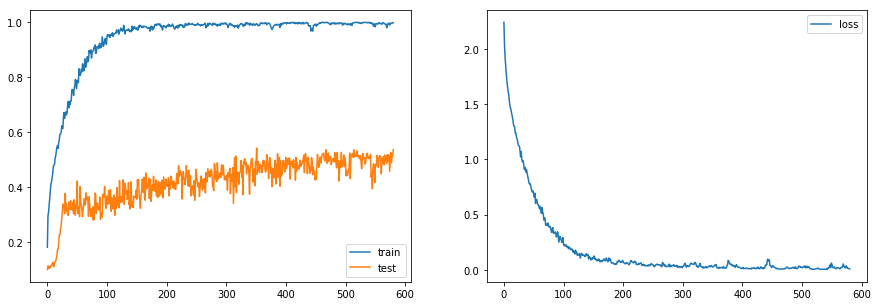

Epoch: 581,Global steps: 11640, xloss: 0.01517, training acc: 99.70%, test acc: 46.92%
Epoch: 582,Global steps: 11660, xloss: 0.00968, training acc: 99.90%, test acc: 53.58%
Epoch: 583,Global steps: 11680, xloss: 0.00645, training acc: 99.90%, test acc: 52.65%
Epoch: 584,Global steps: 11700, xloss: 0.00860, training acc: 99.80%, test acc: 50.74%
Epoch: 585,Global steps: 11720, xloss: 0.00829, training acc: 100.00%, test acc: 52.28%
Epoch: 586,Global steps: 11740, xloss: 0.00947, training acc: 99.90%, test acc: 54.75%
Epoch: 587,Global steps: 11760, xloss: 0.01007, training acc: 99.80%, test acc: 51.58%
Epoch: 588,Global steps: 11780, xloss: 0.01241, training acc: 99.70%, test acc: 45.82%
Epoch: 589,Global steps: 11800, xloss: 0.01117, training acc: 99.80%, test acc: 51.48%
Epoch: 590,Global steps: 11820, xloss: 0.01012, training acc: 99.80%, test acc: 52.96%


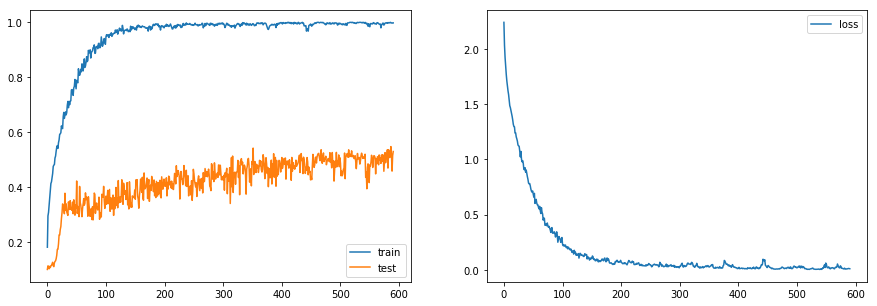

Epoch: 591,Global steps: 11840, xloss: 0.01509, training acc: 99.70%, test acc: 51.82%
Epoch: 592,Global steps: 11860, xloss: 0.01284, training acc: 99.70%, test acc: 46.04%
Epoch: 593,Global steps: 11880, xloss: 0.01783, training acc: 99.80%, test acc: 48.04%
Epoch: 594,Global steps: 11900, xloss: 0.04485, training acc: 98.50%, test acc: 47.44%
Epoch: 595,Global steps: 11920, xloss: 0.02813, training acc: 99.00%, test acc: 51.66%
Epoch: 596,Global steps: 11940, xloss: 0.03467, training acc: 98.80%, test acc: 46.73%
Epoch: 597,Global steps: 11960, xloss: 0.04567, training acc: 98.50%, test acc: 46.72%
Epoch: 598,Global steps: 11980, xloss: 0.04356, training acc: 98.60%, test acc: 45.30%
Epoch: 599,Global steps: 12000, xloss: 0.04149, training acc: 98.80%, test acc: 47.32%
Epoch: 600,Global steps: 12020, xloss: 0.03636, training acc: 98.90%, test acc: 46.97%


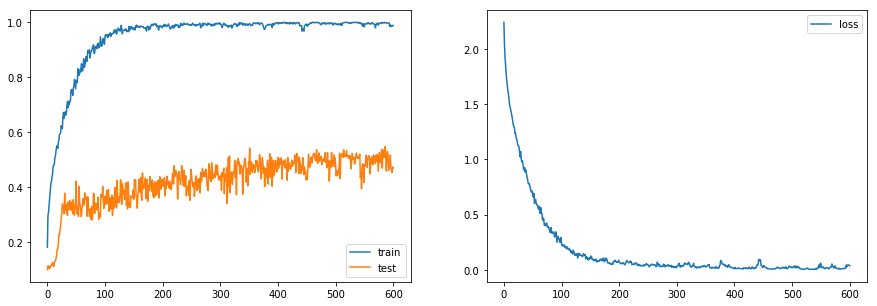

Epoch: 601,Global steps: 12040, xloss: 0.02632, training acc: 99.20%, test acc: 50.79%
Epoch: 602,Global steps: 12060, xloss: 0.01335, training acc: 99.80%, test acc: 51.94%
Epoch: 603,Global steps: 12080, xloss: 0.01039, training acc: 99.80%, test acc: 50.28%
Epoch: 604,Global steps: 12100, xloss: 0.00737, training acc: 99.80%, test acc: 50.56%
Epoch: 605,Global steps: 12120, xloss: 0.00442, training acc: 100.00%, test acc: 51.91%
Epoch: 606,Global steps: 12140, xloss: 0.00377, training acc: 100.00%, test acc: 53.50%
Epoch: 607,Global steps: 12160, xloss: 0.00598, training acc: 99.90%, test acc: 52.48%
Epoch: 608,Global steps: 12180, xloss: 0.00737, training acc: 100.00%, test acc: 54.60%
Epoch: 609,Global steps: 12200, xloss: 0.00745, training acc: 99.80%, test acc: 54.17%
Epoch: 610,Global steps: 12220, xloss: 0.00772, training acc: 99.80%, test acc: 54.87%


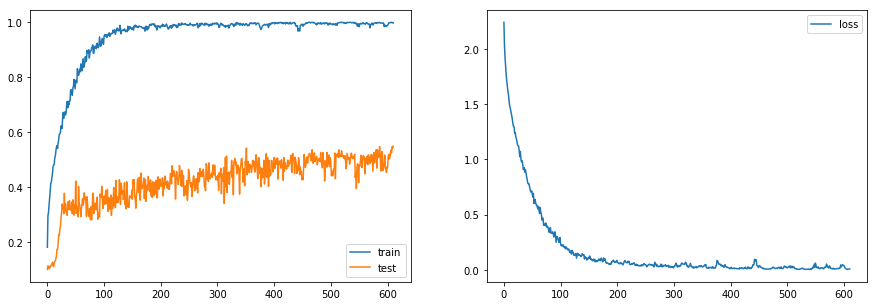

Epoch: 611,Global steps: 12240, xloss: 0.01920, training acc: 99.40%, test acc: 51.82%
Epoch: 612,Global steps: 12260, xloss: 0.01866, training acc: 99.60%, test acc: 51.16%
Epoch: 613,Global steps: 12280, xloss: 0.03073, training acc: 99.10%, test acc: 46.66%
Epoch: 614,Global steps: 12300, xloss: 0.02585, training acc: 99.40%, test acc: 49.51%
Epoch: 615,Global steps: 12320, xloss: 0.01678, training acc: 99.70%, test acc: 51.40%
Epoch: 616,Global steps: 12340, xloss: 0.00593, training acc: 100.00%, test acc: 49.24%
Epoch: 617,Global steps: 12360, xloss: 0.00941, training acc: 99.80%, test acc: 52.76%
Epoch: 618,Global steps: 12380, xloss: 0.01279, training acc: 99.70%, test acc: 53.74%
Epoch: 619,Global steps: 12400, xloss: 0.01215, training acc: 99.70%, test acc: 50.02%
Epoch: 620,Global steps: 12420, xloss: 0.00705, training acc: 100.00%, test acc: 50.77%


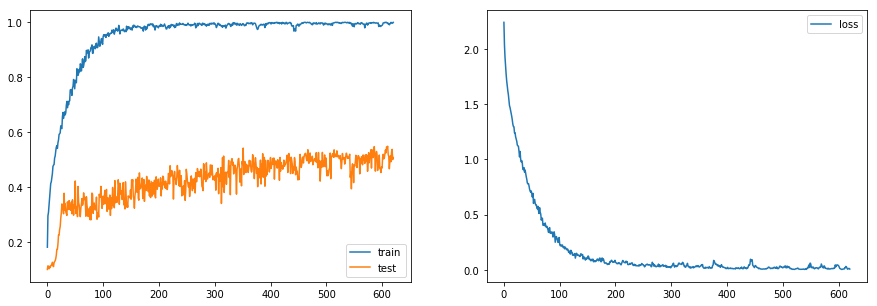

Epoch: 621,Global steps: 12440, xloss: 0.01033, training acc: 99.80%, test acc: 48.32%
Epoch: 622,Global steps: 12460, xloss: 0.00470, training acc: 100.00%, test acc: 47.06%
Epoch: 623,Global steps: 12480, xloss: 0.00382, training acc: 100.00%, test acc: 52.17%
Epoch: 624,Global steps: 12500, xloss: 0.00417, training acc: 99.90%, test acc: 53.61%
Epoch: 625,Global steps: 12520, xloss: 0.00207, training acc: 100.00%, test acc: 53.63%
Epoch: 626,Global steps: 12540, xloss: 0.00275, training acc: 100.00%, test acc: 53.58%
Epoch: 627,Global steps: 12560, xloss: 0.00498, training acc: 99.90%, test acc: 53.73%
Epoch: 628,Global steps: 12580, xloss: 0.00494, training acc: 99.90%, test acc: 53.72%
Epoch: 629,Global steps: 12600, xloss: 0.00639, training acc: 99.90%, test acc: 51.08%
Epoch: 630,Global steps: 12620, xloss: 0.00809, training acc: 99.70%, test acc: 54.55%


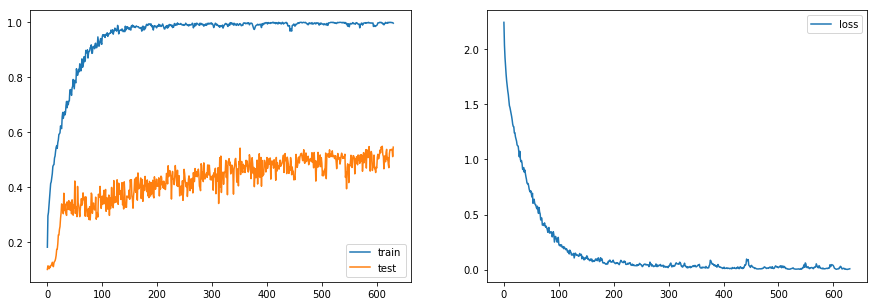

Epoch: 631,Global steps: 12640, xloss: 0.00629, training acc: 99.90%, test acc: 54.53%
Epoch: 632,Global steps: 12660, xloss: 0.00963, training acc: 99.80%, test acc: 51.26%
Epoch: 633,Global steps: 12680, xloss: 0.02581, training acc: 99.10%, test acc: 48.01%
Epoch: 634,Global steps: 12700, xloss: 0.02606, training acc: 99.30%, test acc: 48.45%
Epoch: 635,Global steps: 12720, xloss: 0.02559, training acc: 99.20%, test acc: 48.05%
Epoch: 636,Global steps: 12740, xloss: 0.03343, training acc: 99.10%, test acc: 49.22%
Epoch: 637,Global steps: 12760, xloss: 0.01302, training acc: 99.90%, test acc: 47.48%
Epoch: 638,Global steps: 12780, xloss: 0.01024, training acc: 99.70%, test acc: 48.82%
Epoch: 639,Global steps: 12800, xloss: 0.00745, training acc: 99.90%, test acc: 50.74%
Epoch: 640,Global steps: 12820, xloss: 0.00542, training acc: 100.00%, test acc: 50.04%


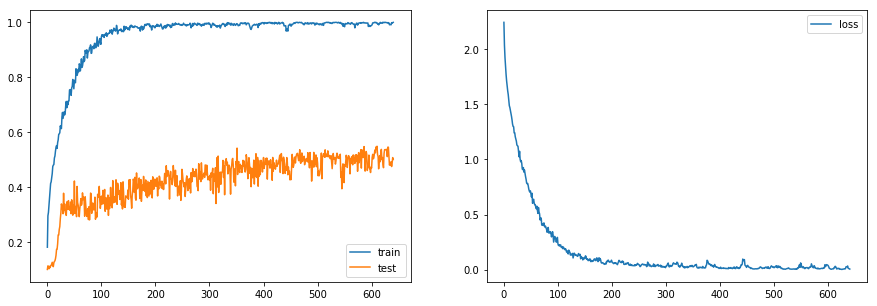

Epoch: 641,Global steps: 12840, xloss: 0.00623, training acc: 99.90%, test acc: 50.26%
Epoch: 642,Global steps: 12860, xloss: 0.00397, training acc: 100.00%, test acc: 50.33%
Epoch: 643,Global steps: 12880, xloss: 0.00365, training acc: 100.00%, test acc: 53.80%
Epoch: 644,Global steps: 12900, xloss: 0.00513, training acc: 99.90%, test acc: 53.26%
Epoch: 645,Global steps: 12920, xloss: 0.00441, training acc: 100.00%, test acc: 52.95%
Epoch: 646,Global steps: 12940, xloss: 0.00360, training acc: 99.90%, test acc: 54.43%
Epoch: 647,Global steps: 12960, xloss: 0.00319, training acc: 100.00%, test acc: 54.53%
Epoch: 648,Global steps: 12980, xloss: 0.00370, training acc: 100.00%, test acc: 54.62%
Epoch: 649,Global steps: 13000, xloss: 0.00221, training acc: 100.00%, test acc: 54.68%
Epoch: 650,Global steps: 13020, xloss: 0.00798, training acc: 99.70%, test acc: 53.32%


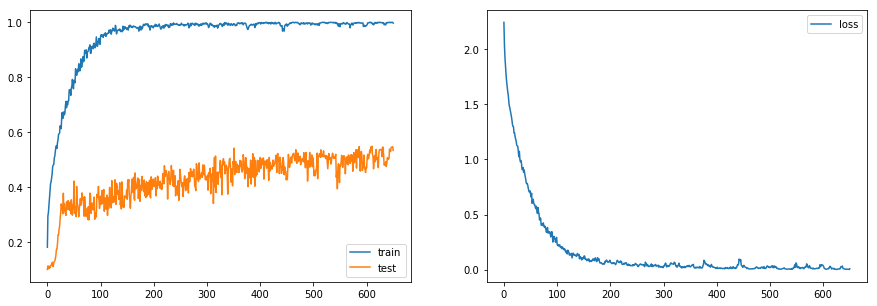

Epoch: 651,Global steps: 13040, xloss: 0.00580, training acc: 100.00%, test acc: 50.73%
Epoch: 652,Global steps: 13060, xloss: 0.00383, training acc: 99.90%, test acc: 53.79%
Epoch: 653,Global steps: 13080, xloss: 0.00327, training acc: 100.00%, test acc: 55.90%
Epoch: 654,Global steps: 13100, xloss: 0.00253, training acc: 100.00%, test acc: 55.76%
Epoch: 655,Global steps: 13120, xloss: 0.00318, training acc: 100.00%, test acc: 55.79%
Epoch: 656,Global steps: 13140, xloss: 0.00344, training acc: 99.90%, test acc: 54.14%
Epoch: 657,Global steps: 13160, xloss: 0.00466, training acc: 100.00%, test acc: 55.40%
Epoch: 658,Global steps: 13180, xloss: 0.00778, training acc: 99.90%, test acc: 54.45%
Epoch: 659,Global steps: 13200, xloss: 0.00574, training acc: 100.00%, test acc: 53.60%
Epoch: 660,Global steps: 13220, xloss: 0.00382, training acc: 100.00%, test acc: 51.91%


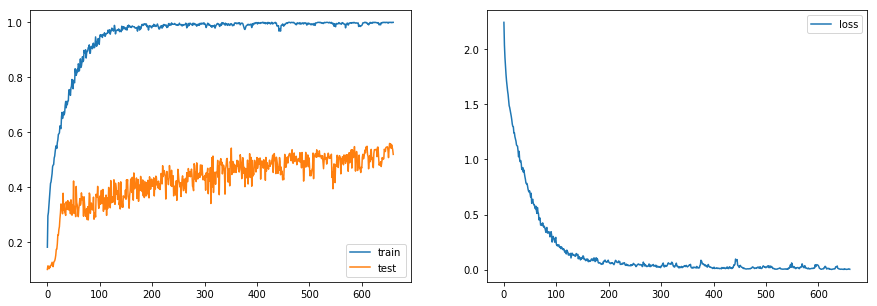

Epoch: 661,Global steps: 13240, xloss: 0.00226, training acc: 100.00%, test acc: 51.35%
Epoch: 662,Global steps: 13260, xloss: 0.00315, training acc: 99.90%, test acc: 52.42%
Epoch: 663,Global steps: 13280, xloss: 0.00395, training acc: 100.00%, test acc: 52.54%
Epoch: 664,Global steps: 13300, xloss: 0.00237, training acc: 100.00%, test acc: 52.63%
Epoch: 665,Global steps: 13320, xloss: 0.00231, training acc: 100.00%, test acc: 52.52%
Epoch: 666,Global steps: 13340, xloss: 0.00460, training acc: 99.90%, test acc: 50.73%
Epoch: 667,Global steps: 13360, xloss: 0.00274, training acc: 100.00%, test acc: 49.28%
Epoch: 668,Global steps: 13380, xloss: 0.00336, training acc: 99.90%, test acc: 51.18%
Epoch: 669,Global steps: 13400, xloss: 0.03257, training acc: 99.30%, test acc: 49.39%
Epoch: 670,Global steps: 13420, xloss: 0.05419, training acc: 98.30%, test acc: 46.21%


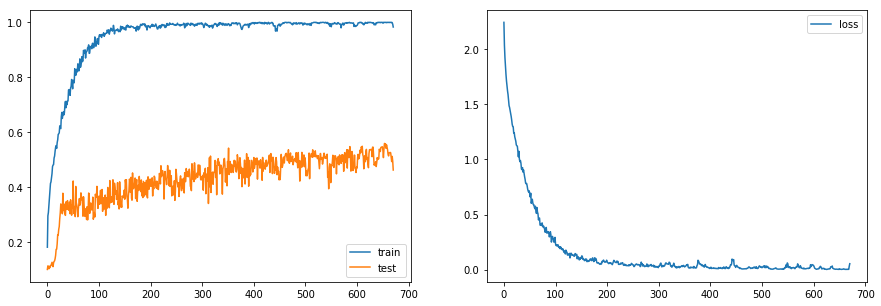

Epoch: 671,Global steps: 13440, xloss: 0.06686, training acc: 97.30%, test acc: 47.39%
Epoch: 672,Global steps: 13460, xloss: 0.08089, training acc: 97.60%, test acc: 42.76%
Epoch: 673,Global steps: 13480, xloss: 0.06561, training acc: 98.10%, test acc: 52.12%
Epoch: 674,Global steps: 13500, xloss: 0.05947, training acc: 98.10%, test acc: 49.71%
Epoch: 675,Global steps: 13520, xloss: 0.04696, training acc: 98.30%, test acc: 50.46%
Epoch: 676,Global steps: 13540, xloss: 0.03286, training acc: 99.40%, test acc: 50.54%
Epoch: 677,Global steps: 13560, xloss: 0.02456, training acc: 99.40%, test acc: 53.37%
Epoch: 678,Global steps: 13580, xloss: 0.02302, training acc: 99.60%, test acc: 51.70%
Epoch: 679,Global steps: 13600, xloss: 0.01666, training acc: 99.70%, test acc: 50.21%
Epoch: 680,Global steps: 13620, xloss: 0.01145, training acc: 99.80%, test acc: 48.41%


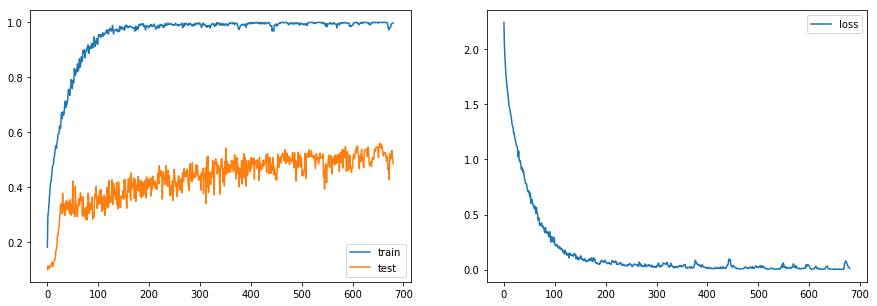

Epoch: 681,Global steps: 13640, xloss: 0.01724, training acc: 99.50%, test acc: 52.09%
Epoch: 682,Global steps: 13660, xloss: 0.00900, training acc: 99.70%, test acc: 50.87%
Epoch: 683,Global steps: 13680, xloss: 0.00475, training acc: 100.00%, test acc: 54.20%
Epoch: 684,Global steps: 13700, xloss: 0.00610, training acc: 100.00%, test acc: 53.12%
Epoch: 685,Global steps: 13720, xloss: 0.00489, training acc: 99.90%, test acc: 55.46%
Epoch: 686,Global steps: 13740, xloss: 0.00310, training acc: 100.00%, test acc: 55.86%
Epoch: 687,Global steps: 13760, xloss: 0.00445, training acc: 99.90%, test acc: 56.38%
Epoch: 688,Global steps: 13780, xloss: 0.00633, training acc: 99.90%, test acc: 55.96%
Epoch: 689,Global steps: 13800, xloss: 0.00618, training acc: 99.80%, test acc: 49.36%
Epoch: 690,Global steps: 13820, xloss: 0.00461, training acc: 100.00%, test acc: 51.25%


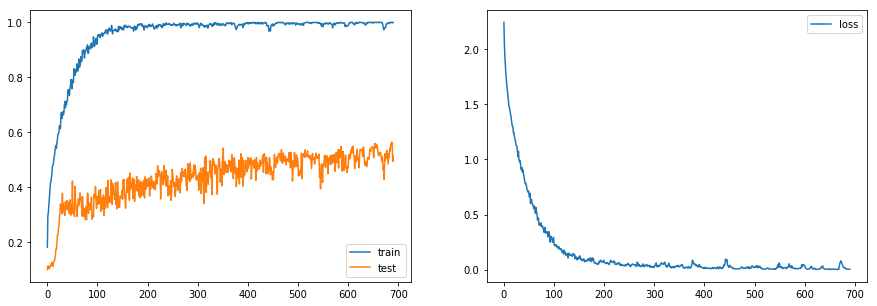

Epoch: 691,Global steps: 13840, xloss: 0.00652, training acc: 99.90%, test acc: 54.04%
Epoch: 692,Global steps: 13860, xloss: 0.00384, training acc: 100.00%, test acc: 52.89%
Epoch: 693,Global steps: 13880, xloss: 0.00211, training acc: 100.00%, test acc: 53.69%
Epoch: 694,Global steps: 13900, xloss: 0.00459, training acc: 100.00%, test acc: 53.99%
Epoch: 695,Global steps: 13920, xloss: 0.00331, training acc: 100.00%, test acc: 54.27%
Epoch: 696,Global steps: 13940, xloss: 0.00632, training acc: 99.80%, test acc: 52.21%
Epoch: 697,Global steps: 13960, xloss: 0.00518, training acc: 99.90%, test acc: 55.09%
Epoch: 698,Global steps: 13980, xloss: 0.00535, training acc: 99.90%, test acc: 54.52%
Epoch: 699,Global steps: 14000, xloss: 0.00695, training acc: 99.70%, test acc: 54.61%
Epoch: 700,Global steps: 14020, xloss: 0.00632, training acc: 99.80%, test acc: 53.26%


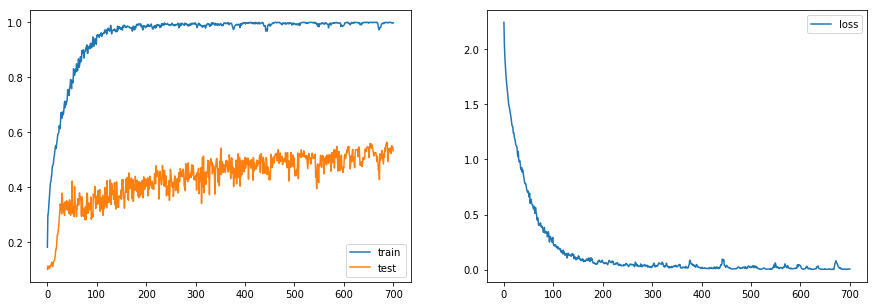

Epoch: 701,Global steps: 14040, xloss: 0.00452, training acc: 99.90%, test acc: 53.58%
Epoch: 702,Global steps: 14060, xloss: 0.00811, training acc: 99.70%, test acc: 52.90%
Epoch: 703,Global steps: 14080, xloss: 0.00941, training acc: 99.70%, test acc: 52.67%
Epoch: 704,Global steps: 14100, xloss: 0.01050, training acc: 99.90%, test acc: 49.83%
Epoch: 705,Global steps: 14120, xloss: 0.01167, training acc: 99.70%, test acc: 47.77%
Epoch: 706,Global steps: 14140, xloss: 0.00367, training acc: 100.00%, test acc: 49.42%
Epoch: 707,Global steps: 14160, xloss: 0.00767, training acc: 99.90%, test acc: 52.75%
Epoch: 708,Global steps: 14180, xloss: 0.00537, training acc: 99.90%, test acc: 52.22%
Epoch: 709,Global steps: 14200, xloss: 0.00464, training acc: 100.00%, test acc: 53.53%
Epoch: 710,Global steps: 14220, xloss: 0.00424, training acc: 99.90%, test acc: 54.33%


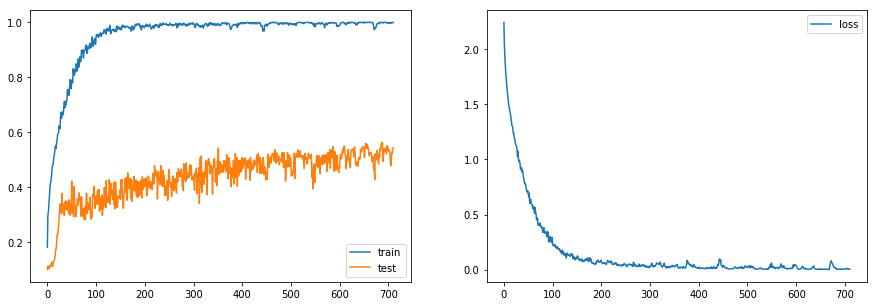

Epoch: 711,Global steps: 14240, xloss: 0.00483, training acc: 99.90%, test acc: 53.45%
Epoch: 712,Global steps: 14260, xloss: 0.00310, training acc: 100.00%, test acc: 55.25%
Epoch: 713,Global steps: 14280, xloss: 0.00189, training acc: 100.00%, test acc: 55.78%
Epoch: 714,Global steps: 14300, xloss: 0.00148, training acc: 100.00%, test acc: 55.63%
Epoch: 715,Global steps: 14320, xloss: 0.00296, training acc: 100.00%, test acc: 54.68%
Epoch: 716,Global steps: 14340, xloss: 0.00146, training acc: 100.00%, test acc: 54.79%
Epoch: 717,Global steps: 14360, xloss: 0.00459, training acc: 99.80%, test acc: 54.37%
Epoch: 718,Global steps: 14380, xloss: 0.00751, training acc: 99.90%, test acc: 51.92%
Epoch: 719,Global steps: 14400, xloss: 0.00627, training acc: 99.90%, test acc: 50.50%
Epoch: 720,Global steps: 14420, xloss: 0.00557, training acc: 99.80%, test acc: 54.29%


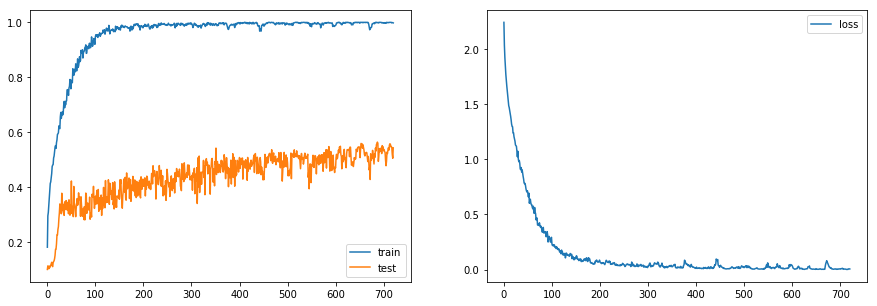

Epoch: 721,Global steps: 14440, xloss: 0.01072, training acc: 99.70%, test acc: 45.31%
Epoch: 722,Global steps: 14460, xloss: 0.01754, training acc: 99.40%, test acc: 49.04%
Epoch: 723,Global steps: 14480, xloss: 0.00887, training acc: 99.90%, test acc: 48.81%
Epoch: 724,Global steps: 14500, xloss: 0.00878, training acc: 100.00%, test acc: 49.53%
Epoch: 725,Global steps: 14520, xloss: 0.00748, training acc: 99.90%, test acc: 50.36%
Epoch: 726,Global steps: 14540, xloss: 0.00800, training acc: 99.80%, test acc: 52.66%
Epoch: 727,Global steps: 14560, xloss: 0.00517, training acc: 100.00%, test acc: 54.40%
Epoch: 728,Global steps: 14580, xloss: 0.00299, training acc: 100.00%, test acc: 54.29%
Epoch: 729,Global steps: 14600, xloss: 0.00209, training acc: 100.00%, test acc: 52.87%
Epoch: 730,Global steps: 14620, xloss: 0.00397, training acc: 100.00%, test acc: 52.72%


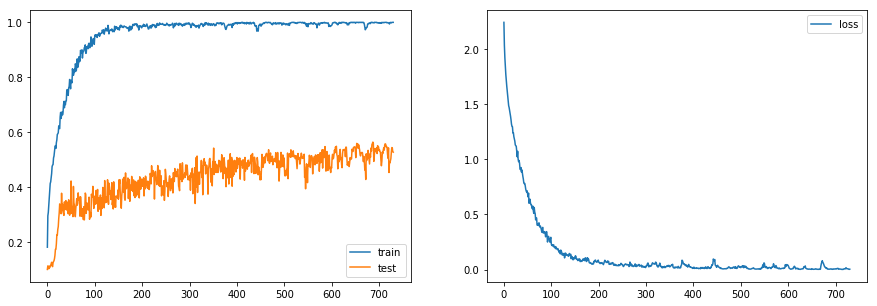

Epoch: 731,Global steps: 14640, xloss: 0.00327, training acc: 100.00%, test acc: 53.18%
Epoch: 732,Global steps: 14660, xloss: 0.00261, training acc: 100.00%, test acc: 52.83%
Epoch: 733,Global steps: 14680, xloss: 0.00200, training acc: 100.00%, test acc: 53.58%
Epoch: 734,Global steps: 14700, xloss: 0.00263, training acc: 100.00%, test acc: 52.72%
Epoch: 735,Global steps: 14720, xloss: 0.00852, training acc: 99.70%, test acc: 53.39%
Epoch: 736,Global steps: 14740, xloss: 0.00944, training acc: 99.80%, test acc: 52.04%
Epoch: 737,Global steps: 14760, xloss: 0.00669, training acc: 99.90%, test acc: 52.97%
Epoch: 738,Global steps: 14780, xloss: 0.00701, training acc: 99.90%, test acc: 51.54%
Epoch: 739,Global steps: 14800, xloss: 0.00780, training acc: 99.90%, test acc: 52.98%
Epoch: 740,Global steps: 14820, xloss: 0.00665, training acc: 99.90%, test acc: 53.36%


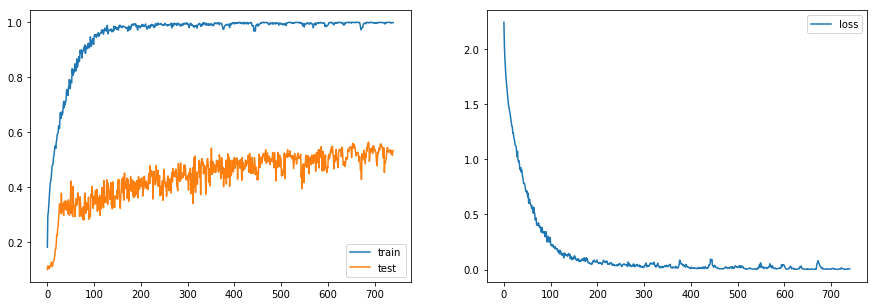

Epoch: 741,Global steps: 14840, xloss: 0.00552, training acc: 99.90%, test acc: 53.63%
Epoch: 742,Global steps: 14860, xloss: 0.00487, training acc: 99.90%, test acc: 48.22%
Epoch: 743,Global steps: 14880, xloss: 0.00626, training acc: 99.80%, test acc: 48.23%
Epoch: 744,Global steps: 14900, xloss: 0.00645, training acc: 99.90%, test acc: 52.01%
Epoch: 745,Global steps: 14920, xloss: 0.00551, training acc: 100.00%, test acc: 52.81%
Epoch: 746,Global steps: 14940, xloss: 0.00314, training acc: 100.00%, test acc: 55.30%
Epoch: 747,Global steps: 14960, xloss: 0.00458, training acc: 99.90%, test acc: 55.24%
Epoch: 748,Global steps: 14980, xloss: 0.00346, training acc: 100.00%, test acc: 53.34%
Epoch: 749,Global steps: 15000, xloss: 0.00487, training acc: 99.90%, test acc: 54.76%
Epoch: 750,Global steps: 15020, xloss: 0.00519, training acc: 99.80%, test acc: 54.22%


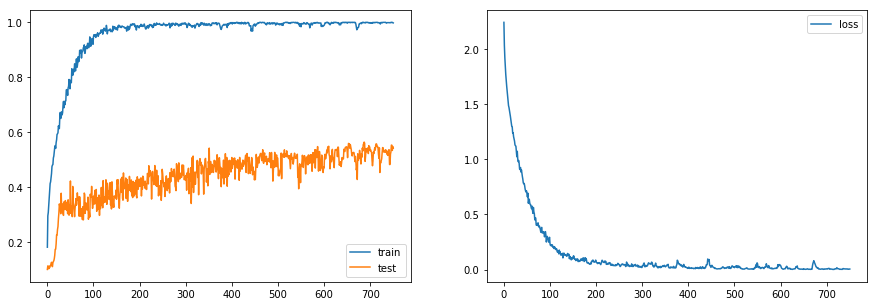

Epoch: 751,Global steps: 15040, xloss: 0.02860, training acc: 99.10%, test acc: 51.76%
Epoch: 752,Global steps: 15060, xloss: 0.02156, training acc: 99.30%, test acc: 50.10%
Epoch: 753,Global steps: 15080, xloss: 0.03306, training acc: 99.20%, test acc: 52.36%
Epoch: 754,Global steps: 15100, xloss: 0.04869, training acc: 98.20%, test acc: 43.24%
Epoch: 755,Global steps: 15120, xloss: 0.08665, training acc: 97.20%, test acc: 46.35%
Epoch: 756,Global steps: 15140, xloss: 0.06584, training acc: 97.80%, test acc: 46.80%
Epoch: 757,Global steps: 15160, xloss: 0.05617, training acc: 97.90%, test acc: 51.78%
Epoch: 758,Global steps: 15180, xloss: 0.05695, training acc: 97.80%, test acc: 44.78%
Epoch: 759,Global steps: 15200, xloss: 0.04059, training acc: 98.70%, test acc: 47.04%
Epoch: 760,Global steps: 15220, xloss: 0.04313, training acc: 98.60%, test acc: 44.82%


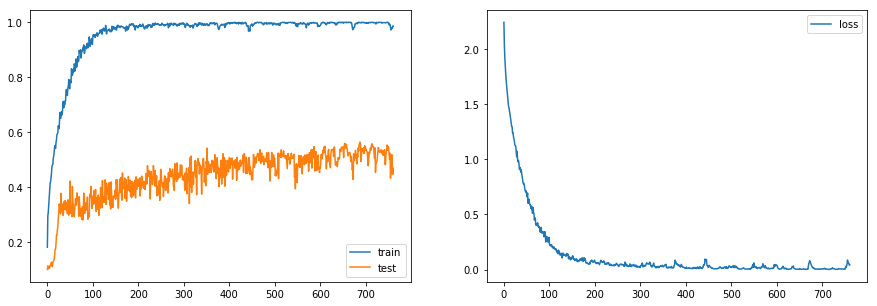

Epoch: 761,Global steps: 15240, xloss: 0.04265, training acc: 98.50%, test acc: 51.18%
Epoch: 762,Global steps: 15260, xloss: 0.04222, training acc: 98.50%, test acc: 48.36%
Epoch: 763,Global steps: 15280, xloss: 0.02710, training acc: 99.30%, test acc: 48.89%
Epoch: 764,Global steps: 15300, xloss: 0.01106, training acc: 99.90%, test acc: 52.11%
Epoch: 765,Global steps: 15320, xloss: 0.01265, training acc: 99.50%, test acc: 50.99%
Epoch: 766,Global steps: 15340, xloss: 0.01280, training acc: 99.80%, test acc: 50.67%
Epoch: 767,Global steps: 15360, xloss: 0.01184, training acc: 99.70%, test acc: 51.95%
Epoch: 768,Global steps: 15380, xloss: 0.00710, training acc: 99.70%, test acc: 48.55%
Epoch: 769,Global steps: 15400, xloss: 0.00799, training acc: 99.90%, test acc: 50.14%
Epoch: 770,Global steps: 15420, xloss: 0.00642, training acc: 100.00%, test acc: 52.14%


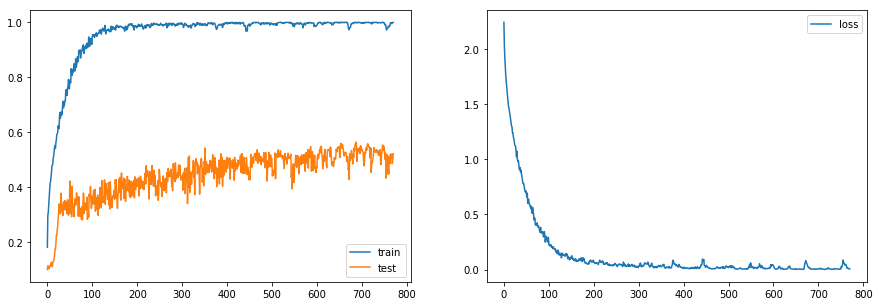

Epoch: 771,Global steps: 15440, xloss: 0.01778, training acc: 99.70%, test acc: 54.01%
Epoch: 772,Global steps: 15460, xloss: 0.01367, training acc: 99.90%, test acc: 50.11%
Epoch: 773,Global steps: 15480, xloss: 0.00914, training acc: 99.90%, test acc: 54.20%
Epoch: 774,Global steps: 15500, xloss: 0.00741, training acc: 99.80%, test acc: 52.68%
Epoch: 775,Global steps: 15520, xloss: 0.00415, training acc: 99.90%, test acc: 54.61%
Epoch: 776,Global steps: 15540, xloss: 0.01207, training acc: 99.70%, test acc: 54.31%
Epoch: 777,Global steps: 15560, xloss: 0.01151, training acc: 99.70%, test acc: 51.70%
Epoch: 778,Global steps: 15580, xloss: 0.00739, training acc: 99.90%, test acc: 52.19%
Epoch: 779,Global steps: 15600, xloss: 0.00888, training acc: 99.80%, test acc: 53.13%
Epoch: 780,Global steps: 15620, xloss: 0.01062, training acc: 99.60%, test acc: 55.16%


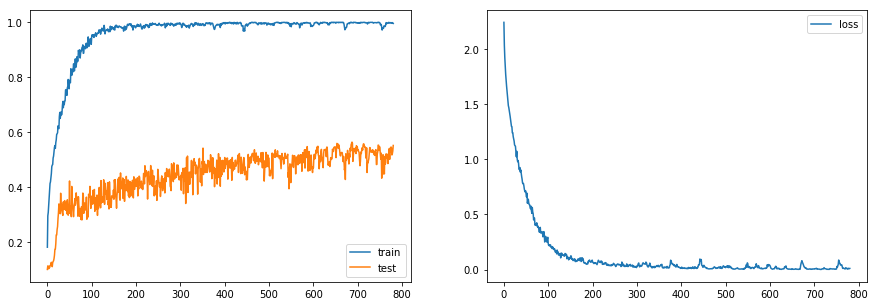

Epoch: 781,Global steps: 15640, xloss: 0.01065, training acc: 99.60%, test acc: 49.58%
Epoch: 782,Global steps: 15660, xloss: 0.00818, training acc: 99.70%, test acc: 51.72%
Epoch: 783,Global steps: 15680, xloss: 0.00884, training acc: 99.80%, test acc: 53.55%
Epoch: 784,Global steps: 15700, xloss: 0.00391, training acc: 100.00%, test acc: 53.32%
Epoch: 785,Global steps: 15720, xloss: 0.00538, training acc: 99.90%, test acc: 52.72%
Epoch: 786,Global steps: 15740, xloss: 0.00362, training acc: 100.00%, test acc: 52.44%
Epoch: 787,Global steps: 15760, xloss: 0.00358, training acc: 100.00%, test acc: 54.87%
Epoch: 788,Global steps: 15780, xloss: 0.00282, training acc: 100.00%, test acc: 53.71%
Epoch: 789,Global steps: 15800, xloss: 0.00387, training acc: 100.00%, test acc: 52.67%
Epoch: 790,Global steps: 15820, xloss: 0.00413, training acc: 99.90%, test acc: 54.28%


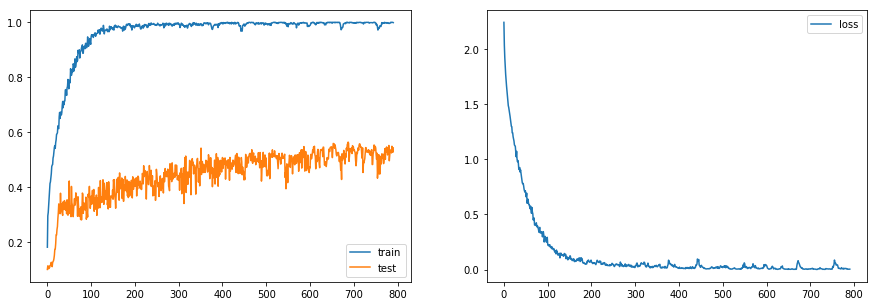

Epoch: 791,Global steps: 15840, xloss: 0.00741, training acc: 99.80%, test acc: 55.58%
Epoch: 792,Global steps: 15860, xloss: 0.00247, training acc: 100.00%, test acc: 55.26%
Epoch: 793,Global steps: 15880, xloss: 0.00347, training acc: 100.00%, test acc: 54.41%
Epoch: 794,Global steps: 15900, xloss: 0.00535, training acc: 99.80%, test acc: 54.52%
Epoch: 795,Global steps: 15920, xloss: 0.00437, training acc: 100.00%, test acc: 50.28%
Epoch: 796,Global steps: 15940, xloss: 0.00423, training acc: 100.00%, test acc: 49.62%
Epoch: 797,Global steps: 15960, xloss: 0.00345, training acc: 100.00%, test acc: 54.57%
Epoch: 798,Global steps: 15980, xloss: 0.00297, training acc: 100.00%, test acc: 55.30%
Epoch: 799,Global steps: 16000, xloss: 0.00379, training acc: 99.90%, test acc: 54.19%
Epoch: 800,Global steps: 16020, xloss: 0.00641, training acc: 99.80%, test acc: 53.50%


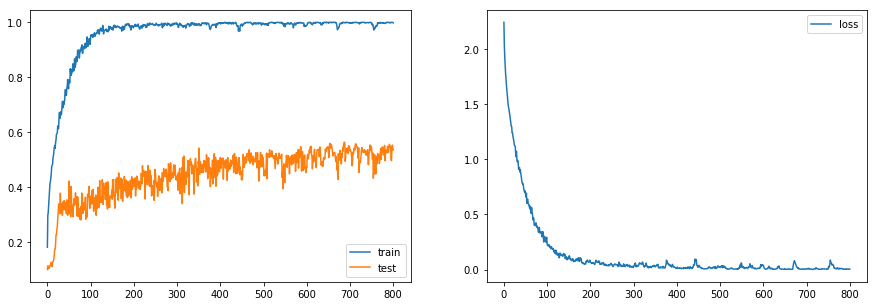

Epoch: 801,Global steps: 16040, xloss: 0.00842, training acc: 99.80%, test acc: 51.93%
Epoch: 802,Global steps: 16060, xloss: 0.01067, training acc: 99.80%, test acc: 53.59%
Epoch: 803,Global steps: 16080, xloss: 0.00407, training acc: 100.00%, test acc: 52.43%
Epoch: 804,Global steps: 16100, xloss: 0.00385, training acc: 100.00%, test acc: 52.83%
Epoch: 805,Global steps: 16120, xloss: 0.00493, training acc: 100.00%, test acc: 53.11%
Epoch: 806,Global steps: 16140, xloss: 0.00552, training acc: 99.90%, test acc: 53.13%
Epoch: 807,Global steps: 16160, xloss: 0.00982, training acc: 99.70%, test acc: 50.90%
Epoch: 808,Global steps: 16180, xloss: 0.03809, training acc: 98.90%, test acc: 51.78%
Epoch: 809,Global steps: 16200, xloss: 0.02250, training acc: 99.30%, test acc: 52.25%
Epoch: 810,Global steps: 16220, xloss: 0.01644, training acc: 99.60%, test acc: 53.76%


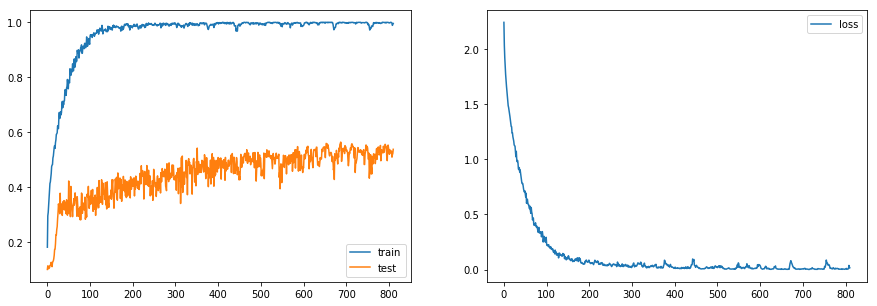

Epoch: 811,Global steps: 16240, xloss: 0.02301, training acc: 99.30%, test acc: 55.61%
Epoch: 812,Global steps: 16260, xloss: 0.01808, training acc: 99.60%, test acc: 52.43%
Epoch: 813,Global steps: 16280, xloss: 0.01423, training acc: 99.80%, test acc: 47.76%
Epoch: 814,Global steps: 16300, xloss: 0.01404, training acc: 99.80%, test acc: 50.30%
Epoch: 815,Global steps: 16320, xloss: 0.01543, training acc: 99.70%, test acc: 53.07%
Epoch: 816,Global steps: 16340, xloss: 0.00870, training acc: 99.80%, test acc: 49.49%
Epoch: 817,Global steps: 16360, xloss: 0.01101, training acc: 99.60%, test acc: 50.06%
Epoch: 818,Global steps: 16380, xloss: 0.00808, training acc: 99.70%, test acc: 53.06%
Epoch: 819,Global steps: 16400, xloss: 0.00740, training acc: 99.90%, test acc: 51.23%
Epoch: 820,Global steps: 16420, xloss: 0.00480, training acc: 99.80%, test acc: 54.46%


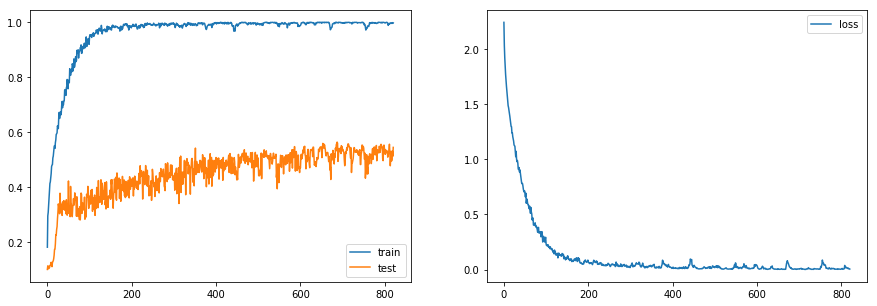

Epoch: 821,Global steps: 16440, xloss: 0.00457, training acc: 99.90%, test acc: 54.27%
Epoch: 822,Global steps: 16460, xloss: 0.00439, training acc: 99.80%, test acc: 54.48%
Epoch: 823,Global steps: 16480, xloss: 0.00593, training acc: 100.00%, test acc: 54.82%
Epoch: 824,Global steps: 16500, xloss: 0.00288, training acc: 100.00%, test acc: 53.03%
Epoch: 825,Global steps: 16520, xloss: 0.00223, training acc: 100.00%, test acc: 53.59%
Epoch: 826,Global steps: 16540, xloss: 0.00342, training acc: 99.90%, test acc: 55.02%
Epoch: 827,Global steps: 16560, xloss: 0.00210, training acc: 100.00%, test acc: 54.88%
Epoch: 828,Global steps: 16580, xloss: 0.00203, training acc: 100.00%, test acc: 54.64%
Epoch: 829,Global steps: 16600, xloss: 0.00233, training acc: 100.00%, test acc: 54.50%
Epoch: 830,Global steps: 16620, xloss: 0.00284, training acc: 100.00%, test acc: 54.43%


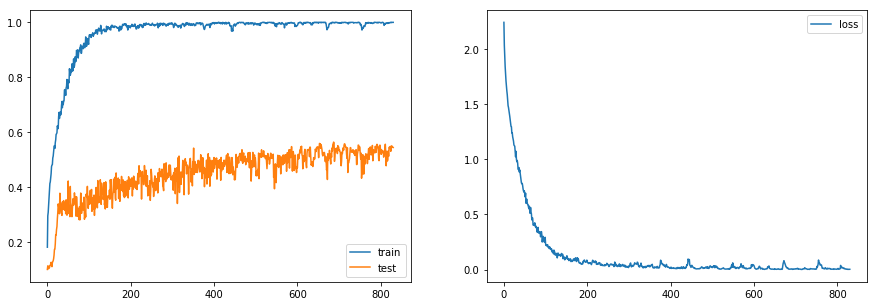

Epoch: 831,Global steps: 16640, xloss: 0.00210, training acc: 100.00%, test acc: 54.15%
Epoch: 832,Global steps: 16660, xloss: 0.00268, training acc: 100.00%, test acc: 53.41%
Epoch: 833,Global steps: 16680, xloss: 0.00272, training acc: 99.90%, test acc: 51.62%
Epoch: 834,Global steps: 16700, xloss: 0.00116, training acc: 100.00%, test acc: 52.91%
Epoch: 835,Global steps: 16720, xloss: 0.00241, training acc: 100.00%, test acc: 54.73%
Epoch: 836,Global steps: 16740, xloss: 0.00379, training acc: 99.90%, test acc: 55.16%
Epoch: 837,Global steps: 16760, xloss: 0.00265, training acc: 100.00%, test acc: 55.22%
Epoch: 838,Global steps: 16780, xloss: 0.00261, training acc: 99.90%, test acc: 55.18%
Epoch: 839,Global steps: 16800, xloss: 0.00266, training acc: 100.00%, test acc: 55.50%
Epoch: 840,Global steps: 16820, xloss: 0.00323, training acc: 100.00%, test acc: 55.52%


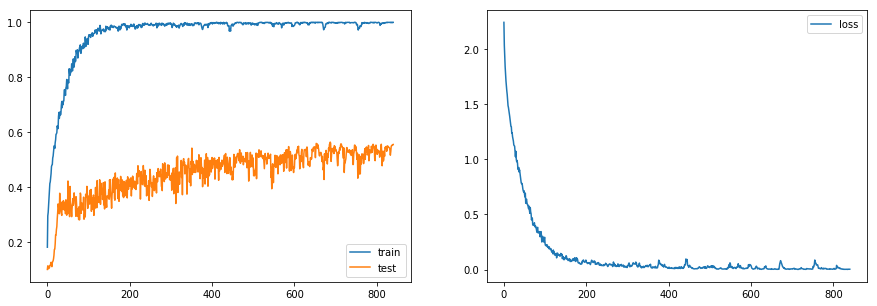

Epoch: 841,Global steps: 16840, xloss: 0.00223, training acc: 100.00%, test acc: 54.53%
Epoch: 842,Global steps: 16860, xloss: 0.00237, training acc: 100.00%, test acc: 54.12%
Epoch: 843,Global steps: 16880, xloss: 0.00335, training acc: 100.00%, test acc: 52.90%
Epoch: 844,Global steps: 16900, xloss: 0.00292, training acc: 100.00%, test acc: 53.58%
Epoch: 845,Global steps: 16920, xloss: 0.00247, training acc: 100.00%, test acc: 53.32%
Epoch: 846,Global steps: 16940, xloss: 0.00226, training acc: 100.00%, test acc: 53.69%
Epoch: 847,Global steps: 16960, xloss: 0.00283, training acc: 100.00%, test acc: 54.23%
Epoch: 848,Global steps: 16980, xloss: 0.00226, training acc: 100.00%, test acc: 53.70%
Epoch: 849,Global steps: 17000, xloss: 0.00239, training acc: 100.00%, test acc: 54.42%
Epoch: 850,Global steps: 17020, xloss: 0.00202, training acc: 100.00%, test acc: 53.85%


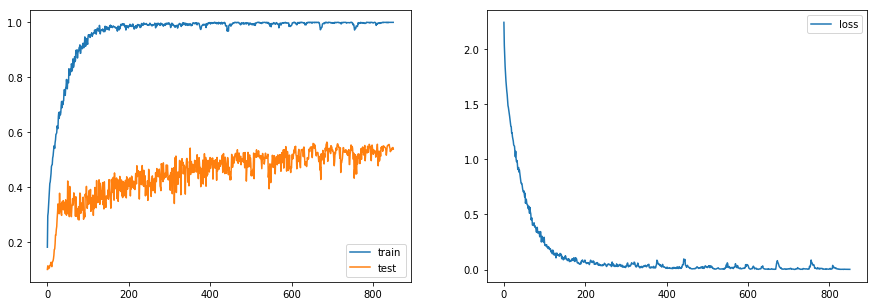

Epoch: 851,Global steps: 17040, xloss: 0.00653, training acc: 99.70%, test acc: 53.22%
Epoch: 852,Global steps: 17060, xloss: 0.01395, training acc: 99.60%, test acc: 51.28%
Epoch: 853,Global steps: 17080, xloss: 0.01429, training acc: 99.60%, test acc: 52.01%
Epoch: 854,Global steps: 17100, xloss: 0.01085, training acc: 99.80%, test acc: 48.44%
Epoch: 855,Global steps: 17120, xloss: 0.01340, training acc: 99.60%, test acc: 49.78%
Epoch: 856,Global steps: 17140, xloss: 0.01739, training acc: 99.10%, test acc: 51.48%
Epoch: 857,Global steps: 17160, xloss: 0.03632, training acc: 99.20%, test acc: 51.13%
Epoch: 858,Global steps: 17180, xloss: 0.05836, training acc: 98.50%, test acc: 47.57%
Epoch: 859,Global steps: 17200, xloss: 0.05180, training acc: 98.30%, test acc: 47.43%
Epoch: 860,Global steps: 17220, xloss: 0.08834, training acc: 97.00%, test acc: 48.80%


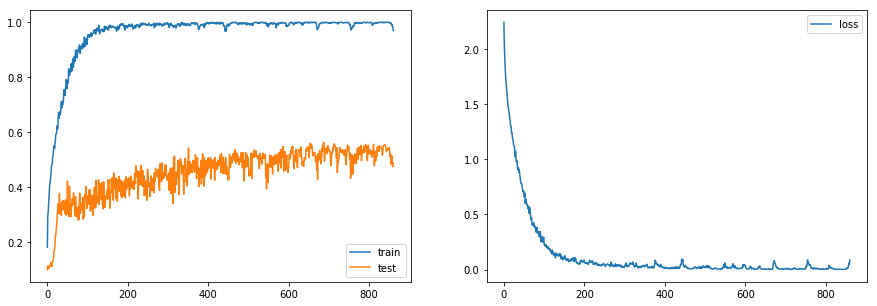

Epoch: 861,Global steps: 17240, xloss: 0.07950, training acc: 97.90%, test acc: 45.49%
Epoch: 862,Global steps: 17260, xloss: 0.04171, training acc: 98.90%, test acc: 51.01%
Epoch: 863,Global steps: 17280, xloss: 0.03599, training acc: 98.90%, test acc: 49.03%
Epoch: 864,Global steps: 17300, xloss: 0.01735, training acc: 99.50%, test acc: 53.90%
Epoch: 865,Global steps: 17320, xloss: 0.02022, training acc: 99.70%, test acc: 53.73%
Epoch: 866,Global steps: 17340, xloss: 0.01765, training acc: 99.60%, test acc: 53.12%
Epoch: 867,Global steps: 17360, xloss: 0.01018, training acc: 99.90%, test acc: 53.17%
Epoch: 868,Global steps: 17380, xloss: 0.01027, training acc: 99.80%, test acc: 50.79%
Epoch: 869,Global steps: 17400, xloss: 0.00369, training acc: 100.00%, test acc: 51.49%
Epoch: 870,Global steps: 17420, xloss: 0.00383, training acc: 100.00%, test acc: 51.70%


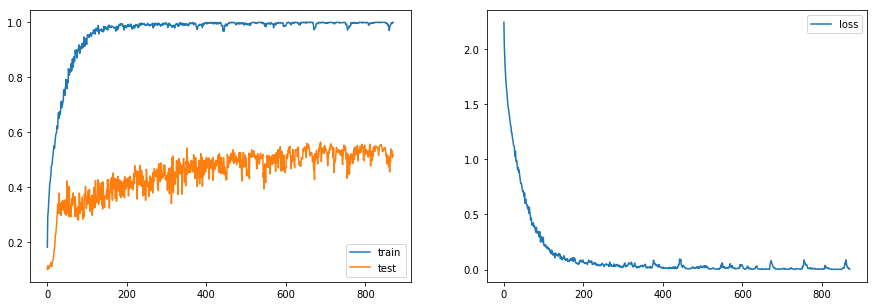

Epoch: 871,Global steps: 17440, xloss: 0.00407, training acc: 100.00%, test acc: 53.25%
Epoch: 872,Global steps: 17460, xloss: 0.00288, training acc: 100.00%, test acc: 53.55%
Epoch: 873,Global steps: 17480, xloss: 0.00297, training acc: 100.00%, test acc: 53.54%
Epoch: 874,Global steps: 17500, xloss: 0.00359, training acc: 99.90%, test acc: 53.42%
Epoch: 875,Global steps: 17520, xloss: 0.00512, training acc: 99.80%, test acc: 54.73%
Epoch: 876,Global steps: 17540, xloss: 0.00424, training acc: 99.90%, test acc: 55.70%
Epoch: 877,Global steps: 17560, xloss: 0.00553, training acc: 100.00%, test acc: 55.10%
Epoch: 878,Global steps: 17580, xloss: 0.00513, training acc: 99.80%, test acc: 53.83%
Epoch: 879,Global steps: 17600, xloss: 0.00398, training acc: 100.00%, test acc: 54.49%
Epoch: 880,Global steps: 17620, xloss: 0.00397, training acc: 99.90%, test acc: 53.05%


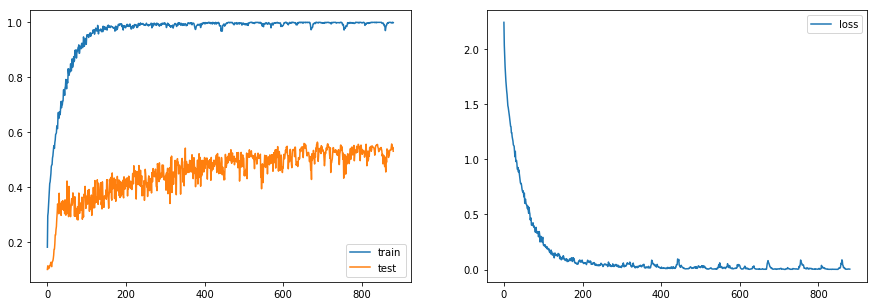

Epoch: 881,Global steps: 17640, xloss: 0.00639, training acc: 99.80%, test acc: 54.59%
Epoch: 882,Global steps: 17660, xloss: 0.00446, training acc: 99.90%, test acc: 54.05%
Epoch: 883,Global steps: 17680, xloss: 0.00344, training acc: 100.00%, test acc: 53.87%
Epoch: 884,Global steps: 17700, xloss: 0.00399, training acc: 100.00%, test acc: 54.75%
Epoch: 885,Global steps: 17720, xloss: 0.00271, training acc: 100.00%, test acc: 54.17%
Epoch: 886,Global steps: 17740, xloss: 0.00201, training acc: 100.00%, test acc: 53.57%
Epoch: 887,Global steps: 17760, xloss: 0.00251, training acc: 100.00%, test acc: 54.06%
Epoch: 888,Global steps: 17780, xloss: 0.00155, training acc: 100.00%, test acc: 54.07%
Epoch: 889,Global steps: 17800, xloss: 0.00158, training acc: 100.00%, test acc: 53.14%
Epoch: 890,Global steps: 17820, xloss: 0.00258, training acc: 99.90%, test acc: 53.88%


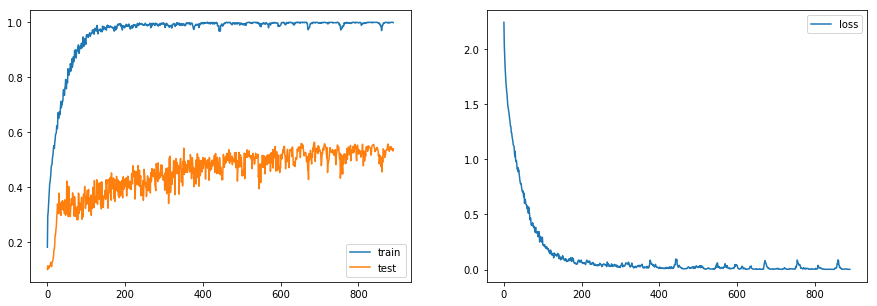

Epoch: 891,Global steps: 17840, xloss: 0.00232, training acc: 100.00%, test acc: 54.99%
Epoch: 892,Global steps: 17860, xloss: 0.00327, training acc: 100.00%, test acc: 55.70%
Epoch: 893,Global steps: 17880, xloss: 0.00348, training acc: 100.00%, test acc: 54.97%
Epoch: 894,Global steps: 17900, xloss: 0.00163, training acc: 100.00%, test acc: 55.52%
Epoch: 895,Global steps: 17920, xloss: 0.00309, training acc: 99.90%, test acc: 57.20%
Epoch: 896,Global steps: 17940, xloss: 0.00168, training acc: 100.00%, test acc: 56.36%
Epoch: 897,Global steps: 17960, xloss: 0.00499, training acc: 99.90%, test acc: 55.87%
Epoch: 898,Global steps: 17980, xloss: 0.00248, training acc: 100.00%, test acc: 55.00%
Epoch: 899,Global steps: 18000, xloss: 0.00197, training acc: 100.00%, test acc: 55.03%
Epoch: 900,Global steps: 18020, xloss: 0.00240, training acc: 100.00%, test acc: 55.02%


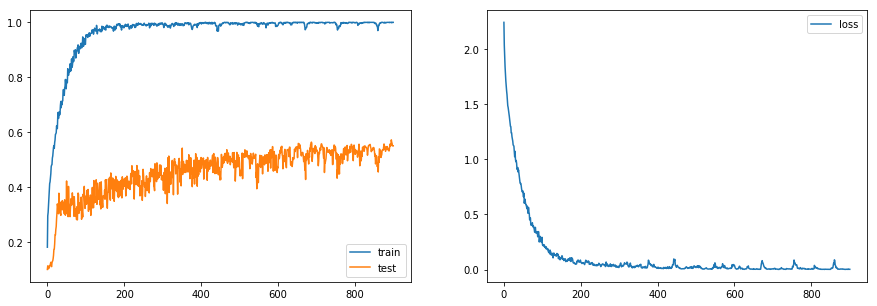

Epoch: 901,Global steps: 18040, xloss: 0.00190, training acc: 100.00%, test acc: 55.25%
Epoch: 902,Global steps: 18060, xloss: 0.00113, training acc: 100.00%, test acc: 55.15%
Epoch: 903,Global steps: 18080, xloss: 0.00276, training acc: 100.00%, test acc: 54.74%
Epoch: 904,Global steps: 18100, xloss: 0.00134, training acc: 100.00%, test acc: 55.16%
Epoch: 905,Global steps: 18120, xloss: 0.00150, training acc: 100.00%, test acc: 55.75%
Epoch: 906,Global steps: 18140, xloss: 0.00089, training acc: 100.00%, test acc: 56.44%
Epoch: 907,Global steps: 18160, xloss: 0.00240, training acc: 99.90%, test acc: 56.23%
Epoch: 908,Global steps: 18180, xloss: 0.00411, training acc: 99.90%, test acc: 55.77%
Epoch: 909,Global steps: 18200, xloss: 0.00427, training acc: 100.00%, test acc: 54.96%
Epoch: 910,Global steps: 18220, xloss: 0.00276, training acc: 100.00%, test acc: 54.37%


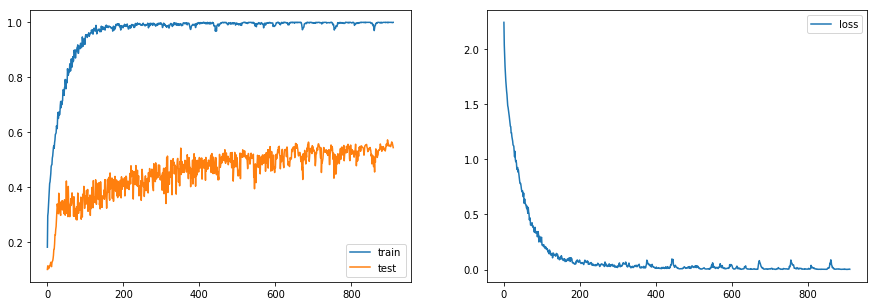

Epoch: 911,Global steps: 18240, xloss: 0.00236, training acc: 100.00%, test acc: 55.02%
Epoch: 912,Global steps: 18260, xloss: 0.00378, training acc: 99.80%, test acc: 53.08%
Epoch: 913,Global steps: 18280, xloss: 0.00727, training acc: 99.90%, test acc: 51.33%
Epoch: 914,Global steps: 18300, xloss: 0.02462, training acc: 99.40%, test acc: 47.69%
Epoch: 915,Global steps: 18320, xloss: 0.01952, training acc: 99.50%, test acc: 50.83%
Epoch: 916,Global steps: 18340, xloss: 0.01956, training acc: 99.50%, test acc: 52.60%
Epoch: 917,Global steps: 18360, xloss: 0.01266, training acc: 99.90%, test acc: 49.16%
Epoch: 918,Global steps: 18380, xloss: 0.01830, training acc: 99.40%, test acc: 47.77%
Epoch: 919,Global steps: 18400, xloss: 0.01650, training acc: 99.60%, test acc: 47.66%
Epoch: 920,Global steps: 18420, xloss: 0.02354, training acc: 99.20%, test acc: 43.90%


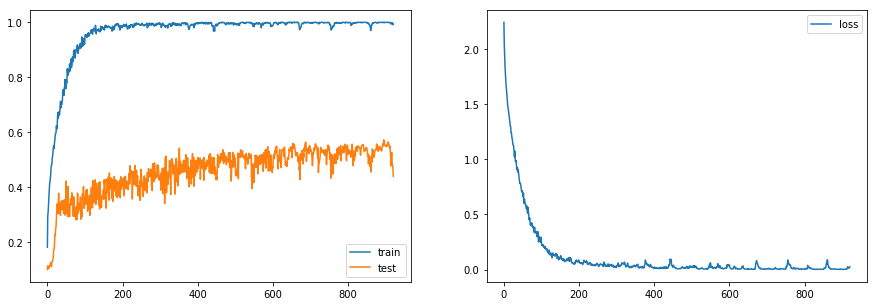

Epoch: 921,Global steps: 18440, xloss: 0.03435, training acc: 98.80%, test acc: 53.68%
Epoch: 922,Global steps: 18460, xloss: 0.03869, training acc: 98.90%, test acc: 48.45%
Epoch: 923,Global steps: 18480, xloss: 0.03301, training acc: 98.80%, test acc: 50.81%
Epoch: 924,Global steps: 18500, xloss: 0.02375, training acc: 99.30%, test acc: 49.45%
Epoch: 925,Global steps: 18520, xloss: 0.01902, training acc: 99.50%, test acc: 48.52%
Epoch: 926,Global steps: 18540, xloss: 0.01841, training acc: 99.50%, test acc: 51.10%
Epoch: 927,Global steps: 18560, xloss: 0.01465, training acc: 99.50%, test acc: 52.99%
Epoch: 928,Global steps: 18580, xloss: 0.01646, training acc: 99.60%, test acc: 54.54%
Epoch: 929,Global steps: 18600, xloss: 0.01289, training acc: 99.50%, test acc: 54.60%
Epoch: 930,Global steps: 18620, xloss: 0.01261, training acc: 99.80%, test acc: 54.06%


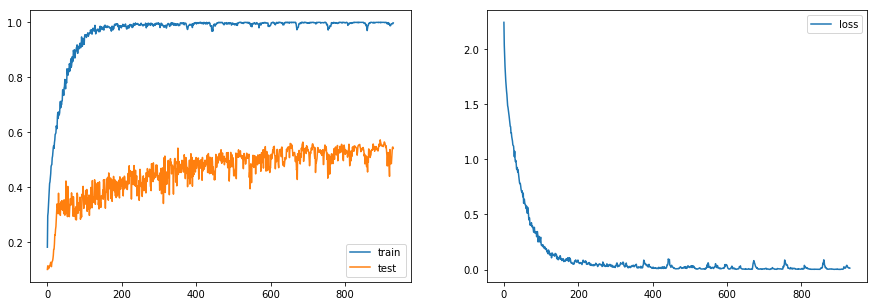

Epoch: 931,Global steps: 18640, xloss: 0.00404, training acc: 100.00%, test acc: 53.88%
Epoch: 932,Global steps: 18660, xloss: 0.00560, training acc: 99.90%, test acc: 56.27%
Epoch: 933,Global steps: 18680, xloss: 0.00315, training acc: 100.00%, test acc: 56.95%
Epoch: 934,Global steps: 18700, xloss: 0.00305, training acc: 100.00%, test acc: 56.27%
Epoch: 935,Global steps: 18720, xloss: 0.00270, training acc: 100.00%, test acc: 55.85%
Epoch: 936,Global steps: 18740, xloss: 0.00562, training acc: 99.90%, test acc: 54.93%
Epoch: 937,Global steps: 18760, xloss: 0.00819, training acc: 99.90%, test acc: 51.97%
Epoch: 938,Global steps: 18780, xloss: 0.00913, training acc: 99.90%, test acc: 53.64%
Epoch: 939,Global steps: 18800, xloss: 0.00692, training acc: 99.90%, test acc: 56.52%
Epoch: 940,Global steps: 18820, xloss: 0.00707, training acc: 99.90%, test acc: 55.01%


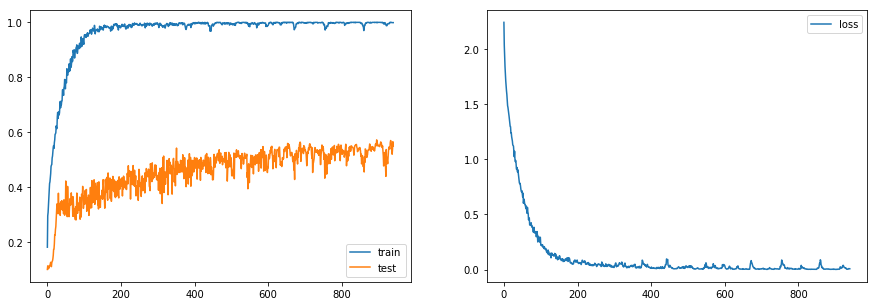

Epoch: 941,Global steps: 18840, xloss: 0.00366, training acc: 100.00%, test acc: 55.80%
Epoch: 942,Global steps: 18860, xloss: 0.00253, training acc: 100.00%, test acc: 55.59%
Epoch: 943,Global steps: 18880, xloss: 0.00811, training acc: 99.90%, test acc: 55.67%
Epoch: 944,Global steps: 18900, xloss: 0.00607, training acc: 99.90%, test acc: 52.34%
Epoch: 945,Global steps: 18920, xloss: 0.01754, training acc: 99.60%, test acc: 52.32%
Epoch: 946,Global steps: 18940, xloss: 0.00915, training acc: 99.60%, test acc: 54.07%
Epoch: 947,Global steps: 18960, xloss: 0.01014, training acc: 99.70%, test acc: 51.88%
Epoch: 948,Global steps: 18980, xloss: 0.00762, training acc: 100.00%, test acc: 50.57%
Epoch: 949,Global steps: 19000, xloss: 0.01081, training acc: 99.60%, test acc: 48.78%
Epoch: 950,Global steps: 19020, xloss: 0.04399, training acc: 98.60%, test acc: 53.75%


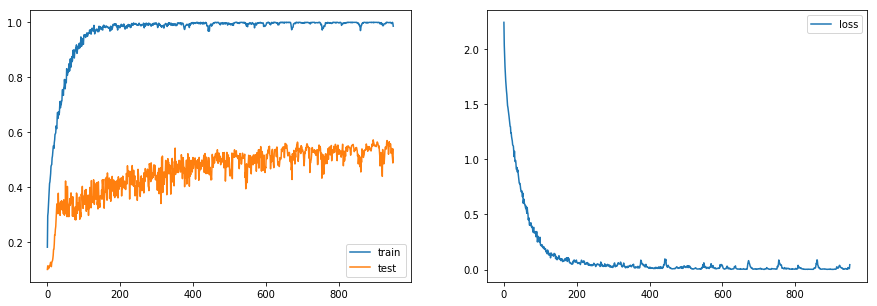

Epoch: 951,Global steps: 19040, xloss: 0.03899, training acc: 98.90%, test acc: 47.65%
Epoch: 952,Global steps: 19060, xloss: 0.02007, training acc: 99.40%, test acc: 53.32%
Epoch: 953,Global steps: 19080, xloss: 0.01494, training acc: 99.50%, test acc: 55.51%
Epoch: 954,Global steps: 19100, xloss: 0.01103, training acc: 99.50%, test acc: 49.72%
Epoch: 955,Global steps: 19120, xloss: 0.01424, training acc: 99.60%, test acc: 52.62%
Epoch: 956,Global steps: 19140, xloss: 0.01101, training acc: 99.50%, test acc: 54.96%
Epoch: 957,Global steps: 19160, xloss: 0.00816, training acc: 99.80%, test acc: 50.39%
Epoch: 958,Global steps: 19180, xloss: 0.00488, training acc: 100.00%, test acc: 51.34%
Epoch: 959,Global steps: 19200, xloss: 0.00327, training acc: 100.00%, test acc: 53.73%
Epoch: 960,Global steps: 19220, xloss: 0.00415, training acc: 99.90%, test acc: 53.62%


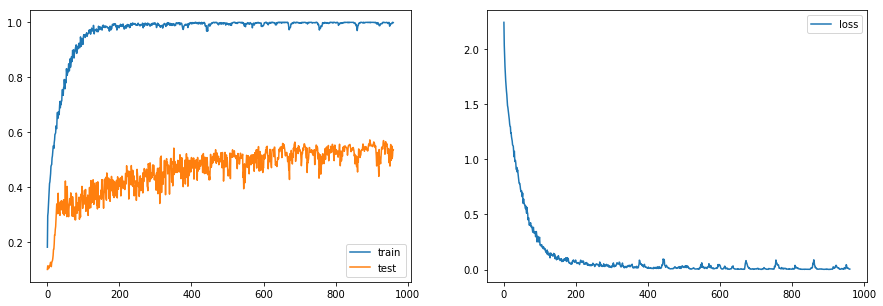

Epoch: 961,Global steps: 19240, xloss: 0.00615, training acc: 99.90%, test acc: 53.43%
Epoch: 962,Global steps: 19260, xloss: 0.00414, training acc: 100.00%, test acc: 52.03%
Epoch: 963,Global steps: 19280, xloss: 0.00556, training acc: 99.80%, test acc: 51.45%
Epoch: 964,Global steps: 19300, xloss: 0.00324, training acc: 100.00%, test acc: 51.59%
Epoch: 965,Global steps: 19320, xloss: 0.00283, training acc: 100.00%, test acc: 51.96%
Epoch: 966,Global steps: 19340, xloss: 0.00294, training acc: 99.90%, test acc: 53.51%
Epoch: 967,Global steps: 19360, xloss: 0.00167, training acc: 100.00%, test acc: 54.35%
Epoch: 968,Global steps: 19380, xloss: 0.00274, training acc: 99.90%, test acc: 55.94%
Epoch: 969,Global steps: 19400, xloss: 0.00293, training acc: 100.00%, test acc: 54.95%
Epoch: 970,Global steps: 19420, xloss: 0.00217, training acc: 100.00%, test acc: 55.11%


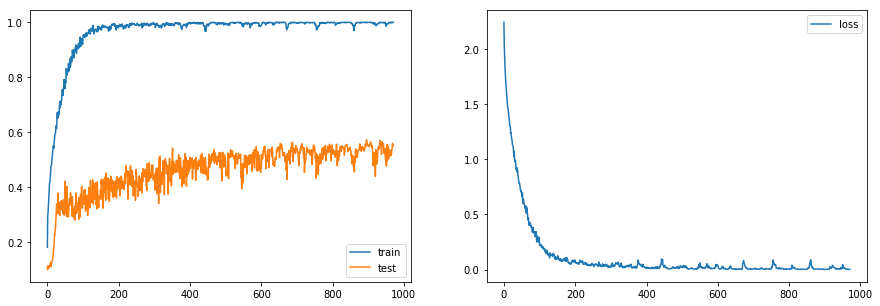

Epoch: 971,Global steps: 19440, xloss: 0.00150, training acc: 100.00%, test acc: 55.25%
Epoch: 972,Global steps: 19460, xloss: 0.00208, training acc: 100.00%, test acc: 55.96%
Epoch: 973,Global steps: 19480, xloss: 0.00114, training acc: 100.00%, test acc: 56.27%
Epoch: 974,Global steps: 19500, xloss: 0.00146, training acc: 100.00%, test acc: 55.94%
Epoch: 975,Global steps: 19520, xloss: 0.00124, training acc: 100.00%, test acc: 55.53%
Epoch: 976,Global steps: 19540, xloss: 0.00125, training acc: 100.00%, test acc: 55.70%
Epoch: 977,Global steps: 19560, xloss: 0.00099, training acc: 100.00%, test acc: 55.39%
Epoch: 978,Global steps: 19580, xloss: 0.00116, training acc: 100.00%, test acc: 55.24%
Epoch: 979,Global steps: 19600, xloss: 0.00158, training acc: 100.00%, test acc: 55.79%
Epoch: 980,Global steps: 19620, xloss: 0.00164, training acc: 100.00%, test acc: 56.05%


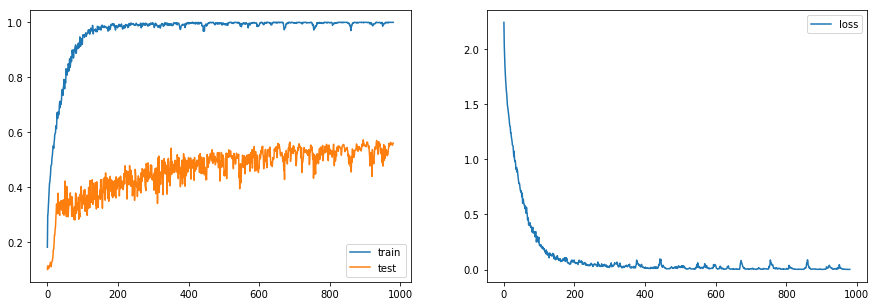

Epoch: 981,Global steps: 19640, xloss: 0.00138, training acc: 100.00%, test acc: 55.59%
Epoch: 982,Global steps: 19660, xloss: 0.00152, training acc: 100.00%, test acc: 55.72%
Epoch: 983,Global steps: 19680, xloss: 0.00118, training acc: 100.00%, test acc: 56.24%
Epoch: 984,Global steps: 19700, xloss: 0.00095, training acc: 100.00%, test acc: 56.51%
Epoch: 985,Global steps: 19720, xloss: 0.00120, training acc: 100.00%, test acc: 57.13%
Epoch: 986,Global steps: 19740, xloss: 0.00114, training acc: 100.00%, test acc: 57.22%
Epoch: 987,Global steps: 19760, xloss: 0.00242, training acc: 100.00%, test acc: 56.43%
Epoch: 988,Global steps: 19780, xloss: 0.00212, training acc: 100.00%, test acc: 56.65%
Epoch: 989,Global steps: 19800, xloss: 0.00136, training acc: 100.00%, test acc: 57.05%
Epoch: 990,Global steps: 19820, xloss: 0.00168, training acc: 100.00%, test acc: 56.51%


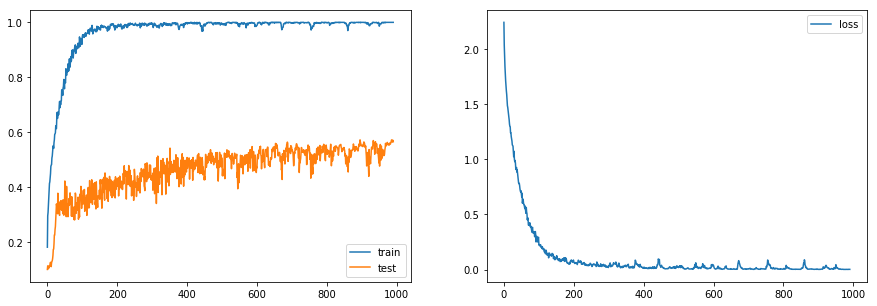

Epoch: 991,Global steps: 19840, xloss: 0.00110, training acc: 100.00%, test acc: 55.38%
Epoch: 992,Global steps: 19860, xloss: 0.00143, training acc: 100.00%, test acc: 55.76%
Epoch: 993,Global steps: 19880, xloss: 0.00281, training acc: 99.90%, test acc: 53.83%
Epoch: 994,Global steps: 19900, xloss: 0.00749, training acc: 99.80%, test acc: 53.30%
Epoch: 995,Global steps: 19920, xloss: 0.00559, training acc: 99.90%, test acc: 54.83%
Epoch: 996,Global steps: 19940, xloss: 0.00865, training acc: 99.80%, test acc: 50.48%
Epoch: 997,Global steps: 19960, xloss: 0.02358, training acc: 99.30%, test acc: 52.60%
Epoch: 998,Global steps: 19980, xloss: 0.02281, training acc: 99.50%, test acc: 48.59%
Epoch: 999,Global steps: 20000, xloss: 0.03698, training acc: 99.10%, test acc: 52.11%
Epoch: 1000,Global steps: 20020, xloss: 0.02069, training acc: 99.30%, test acc: 51.11%


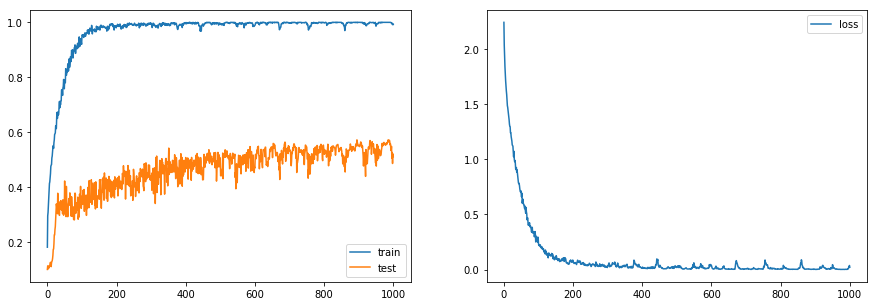

In [10]:
train_array = [];test_array=[]; loss_array=[]
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc =  sess.run([xloss,train_op, accuracy], {inp: trainx[ran_from:ran_to],
                                             lbl: trainy[ran_from:ran_to],
                                             training_cnn:True})
        train_acc += acc; train_loss += xl; 
    train_acc /= nr_batch_train; train_loss /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        test_acc += sess.run(accuracy, {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
    test_acc /= nr_batch_test; test_array.append(test_acc)
    print("Epoch: {},Global steps: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_acc * 100,test_acc*100))
    
    if (epoch != 0) & (epoch % 10 == 0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_array)
        plt.plot(test_array)
        plt.legend(['train','test'])
        plt.subplot(122)
        plt.plot(loss_array)
        plt.legend(['loss'])
        plt.show()